In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
!unzip "/content/drive/MyDrive/CV Project/archive.zip" -d "/content/drive/MyDrive/CV Project/brain_tumor_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2013.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2014.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2015.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2016.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2017.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2018.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2019.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/202.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2020.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2021.png  
  inflating: /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2022.png  
  inflating: /c

#UNET

https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.up4 = self.up_conv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = self.up_conv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = self.up_conv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = self.up_conv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Output Layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder path
        d4 = self.up4(b)
        d4 = torch.cat([e4, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([e3, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([e2, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([e1, d1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))


model = UNet()
print(model)

NameError: name 'nn' is not defined

# Metrics

In [ ]:
smooth = 1e-15

def dice_coefficient(true_mask, pred_mask):
    """
    Dice coefficient metric for evaluating the similarity between ground truth and predicted segmentation masks.

    Args:
        true_mask: Ground truth segmentation masks (tensor).
        pred_mask: Predicted segmentation masks (tensor).

    Returns:
        Dice coefficient score.
    """
    true_mask = true_mask.contiguous().view(-1)  # Flatten the ground truth masks
    pred_mask = pred_mask.contiguous().view(-1)  # Flatten the predicted masks

    intersection = (true_mask * pred_mask).sum()  # Calculate the intersection between the masks

    return (2. * intersection + smooth) / (true_mask.sum() + pred_mask.sum() + smooth)

def dice_coefficient_loss(true_mask, pred_mask):
    """
    Dice loss function for training a model based on the Dice coefficient.

    Args:
        true_mask: Ground truth segmentation masks (tensor).
        pred_mask: Predicted segmentation masks (tensor).

    Returns:
        Dice loss value.
    """
    dice = dice_coefficient(true_mask, pred_mask)
    return -torch.log(dice)

#Train


In [ ]:
# Global parameters
Height = 256
Width = 256

def create_folder(path):
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path_dataset, splitting_ratio=0.2):
    images = sorted(glob(os.path.join(path_dataset, "images", "*.png")))
    masks = sorted(glob(os.path.join(path_dataset, "masks", "*.png")))

    # Ensure that images and masks have corresponding files
    image_names = [os.path.basename(img_path).split('.')[0] for img_path in images]
    mask_names = [os.path.basename(mask_path).split('.')[0] for mask_path in masks]
    common_names = list(set(image_names) & set(mask_names))  # Find common image and mask names

    images = [os.path.join(path_dataset, "images", f"{name}.png") for name in common_names]
    masks = [os.path.join(path_dataset, "masks", f"{name}.png") for name in common_names]

    splitting_size = int(len(images) * splitting_ratio)
    train_img, val_img = train_test_split(images, test_size=splitting_size, random_state=42)
    train_mask, val_mask = train_test_split(masks, test_size=splitting_size, random_state=42)

    train_img, test_img = train_test_split(train_img, test_size=splitting_size, random_state=42)
    train_mask, test_mask = train_test_split(train_mask, test_size=splitting_size, random_state=42)

    return (train_img, train_mask), (val_img, val_mask), (test_img, test_mask)

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
        img = cv2.resize(img, (Width, Height))
        img = img / 255.0  # Normalize
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (Width, Height))
        mask = mask / 255.0  # Normalize
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask

def get_dataloader(image_paths, mask_paths, batch_size=16, shuffle=True):
    dataset = BrainTumorDataset(image_paths, mask_paths)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)

    create_folder("/content/drive/MyDrive/CV Project/files")

    batch_size = 16
    lr = 1e-4
    epochs_num = 50
    model_path = os.path.join("/content/drive/MyDrive/CV Project/files", "model.pth")
    path_csv = os.path.join("/content/drive/MyDrive/CV Project/files", "log.csv")
    dataset_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset"
    (train_img, train_mask), (val_img, val_mask), (test_img, test_mask) = load_dataset(dataset_path)

    print(f"Training: {len(train_img)} - {len(train_mask)}")
    print(f"Validation: {len(val_img)} - {len(val_mask)}")
    print(f"Testing: {len(test_img)} - {len(test_mask)}")

    train_loader = get_dataloader(train_img, train_mask, batch_size=16)
    val_loader = get_dataloader(val_img, val_mask, batch_size=16)
    test_loader = get_dataloader(test_img, test_mask, batch_size=16)

Training: 1840 - 1840
Validation: 612 - 612
Testing: 612 - 612


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(f"Number of images: {len(train_img)}")
print(f"Number of masks: {len(train_mask)}")

Number of images: 1840
Number of masks: 1840


In [ ]:
# Define model
model = UNet().to(DEVICE)

# Loss function and optimizer
criterion = dice_coefficient_loss  # Use the PyTorch version of Dice loss
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7, verbose=True)

# Early stopping
best_loss = float("inf")
stagnant_epochs = 0
patience = 20
checkpoint_path = "/content/drive/MyDrive/CV Project/files/model.pth"
with open(path_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Dice coeff", "Val Dice coeff"])

epochs_num = 50
# Training loop
for epoch in range(epochs_num):
    model.train()
    train_loss, train_dice = 0.0, 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks).mean().item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks).mean().item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs_num}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice coeff:{train_dice:.4f}, Val Dice coeff:{val_dice:.4f}")

    with open(path_csv, mode='a', newline='') as file:
      writer = csv.writer(file)
      writer.writerow([epoch + 1, train_loss, val_loss, train_dice, val_dice])

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        stagnant_epochs = 0
        torch.save(model.state_dict(), checkpoint_path)
        print("Model saved!")
    else:
        stagnant_epochs += 1

    # Early stopping
    if stagnant_epochs >= patience:
        print("Early stopping triggered.")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/115 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 1/50, Train Loss: 2.6191, Val Loss: 2.4011, Train Dice coeff:0.0762, Val Dice coeff:0.0927
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 2/50, Train Loss: 2.2945, Val Loss: 2.1594, Train Dice coeff:0.1031, Val Dice coeff:0.1180
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 3/50, Train Loss: 2.0795, Val Loss: 1.9715, Train Dice coeff:0.1274, Val Dice coeff:0.1424
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 4/50, Train Loss: 1.8756, Val Loss: 1.8597, Train Dice coeff:0.1564, Val Dice coeff:0.1588
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 5/50, Train Loss: 1.6215, Val Loss: 1.4838, Train Dice coeff:0.2010, Val Dice coeff:0.2312
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 6/50, Train Loss: 1.4066, Val Loss: 1.3690, Train Dice coeff:0.2492, Val Dice coeff:0.2595
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 7/50, Train Loss: 1.2133, Val Loss: 1.1719, Train Dice coeff:0.3016, Val Dice coeff:0.3158
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 8/50, Train Loss: 1.0303, Val Loss: 0.9961, Train Dice coeff:0.3610, Val Dice coeff:0.3764
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 9/50, Train Loss: 0.8897, Val Loss: 0.8304, Train Dice coeff:0.4151, Val Dice coeff:0.4427
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 10/50, Train Loss: 0.7320, Val Loss: 0.7628, Train Dice coeff:0.4843, Val Dice coeff:0.4745
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 11/50, Train Loss: 0.6533, Val Loss: 0.6847, Train Dice coeff:0.5236, Val Dice coeff:0.5112
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 12/50, Train Loss: 0.5667, Val Loss: 0.5532, Train Dice coeff:0.5708, Val Dice coeff:0.5805
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.19it/s]


Epoch 13/50, Train Loss: 0.4765, Val Loss: 0.5764, Train Dice coeff:0.6235, Val Dice coeff:0.5695


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 14/50, Train Loss: 0.4142, Val Loss: 0.5071, Train Dice coeff:0.6626, Val Dice coeff:0.6093
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 15/50, Train Loss: 0.3735, Val Loss: 0.4417, Train Dice coeff:0.6903, Val Dice coeff:0.6462
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 16/50, Train Loss: 0.3354, Val Loss: 0.3997, Train Dice coeff:0.7168, Val Dice coeff:0.6755
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 17/50, Train Loss: 0.3215, Val Loss: 0.3862, Train Dice coeff:0.7268, Val Dice coeff:0.6853
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 18/50, Train Loss: 0.2818, Val Loss: 0.3451, Train Dice coeff:0.7557, Val Dice coeff:0.7130
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 19/50, Train Loss: 0.2591, Val Loss: 0.3539, Train Dice coeff:0.7729, Val Dice coeff:0.7074


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 20/50, Train Loss: 0.2261, Val Loss: 0.3241, Train Dice coeff:0.7986, Val Dice coeff:0.7283
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 21/50, Train Loss: 0.2090, Val Loss: 0.3471, Train Dice coeff:0.8123, Val Dice coeff:0.7139


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 22/50, Train Loss: 0.2049, Val Loss: 0.3295, Train Dice coeff:0.8157, Val Dice coeff:0.7254


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 23/50, Train Loss: 0.1876, Val Loss: 0.3238, Train Dice coeff:0.8298, Val Dice coeff:0.7289
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 24/50, Train Loss: 0.1891, Val Loss: 0.3046, Train Dice coeff:0.8286, Val Dice coeff:0.7405
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 25/50, Train Loss: 0.1755, Val Loss: 0.2974, Train Dice coeff:0.8397, Val Dice coeff:0.7486
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 26/50, Train Loss: 0.1656, Val Loss: 0.4784, Train Dice coeff:0.8479, Val Dice coeff:0.6401


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 27/50, Train Loss: 0.1773, Val Loss: 0.3232, Train Dice coeff:0.8383, Val Dice coeff:0.7303


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 28/50, Train Loss: 0.1974, Val Loss: 0.3181, Train Dice coeff:0.8223, Val Dice coeff:0.7318


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 29/50, Train Loss: 0.1691, Val Loss: 0.2726, Train Dice coeff:0.8454, Val Dice coeff:0.7664
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 30/50, Train Loss: 0.1454, Val Loss: 0.2540, Train Dice coeff:0.8653, Val Dice coeff:0.7805
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 31/50, Train Loss: 0.1364, Val Loss: 0.2684, Train Dice coeff:0.8731, Val Dice coeff:0.7695


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 32/50, Train Loss: 0.1348, Val Loss: 0.2793, Train Dice coeff:0.8745, Val Dice coeff:0.7597


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 33/50, Train Loss: 0.1577, Val Loss: 0.2765, Train Dice coeff:0.8551, Val Dice coeff:0.7642


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 34/50, Train Loss: 0.1219, Val Loss: 0.2481, Train Dice coeff:0.8857, Val Dice coeff:0.7851
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 35/50, Train Loss: 0.1133, Val Loss: 0.2487, Train Dice coeff:0.8932, Val Dice coeff:0.7850


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 36/50, Train Loss: 0.1144, Val Loss: 0.2511, Train Dice coeff:0.8923, Val Dice coeff:0.7832


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 37/50, Train Loss: 0.1050, Val Loss: 0.2381, Train Dice coeff:0.9006, Val Dice coeff:0.7932
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 38/50, Train Loss: 0.1005, Val Loss: 0.2462, Train Dice coeff:0.9047, Val Dice coeff:0.7862


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 39/50, Train Loss: 0.0933, Val Loss: 0.2367, Train Dice coeff:0.9112, Val Dice coeff:0.7943
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 40/50, Train Loss: 0.0882, Val Loss: 0.2345, Train Dice coeff:0.9158, Val Dice coeff:0.7957
Model saved!


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 41/50, Train Loss: 0.0836, Val Loss: 0.2551, Train Dice coeff:0.9201, Val Dice coeff:0.7800


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 42/50, Train Loss: 0.0803, Val Loss: 0.2350, Train Dice coeff:0.9231, Val Dice coeff:0.7953


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 43/50, Train Loss: 0.0769, Val Loss: 0.2331, Train Dice coeff:0.9262, Val Dice coeff:0.7968
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 44/50, Train Loss: 0.0758, Val Loss: 0.2313, Train Dice coeff:0.9272, Val Dice coeff:0.7979
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 45/50, Train Loss: 0.0724, Val Loss: 0.2226, Train Dice coeff:0.9304, Val Dice coeff:0.8050
Model saved!


100%|██████████| 115/115 [01:37<00:00,  1.18it/s]


Epoch 46/50, Train Loss: 0.0721, Val Loss: 0.2410, Train Dice coeff:0.9306, Val Dice coeff:0.7904


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 47/50, Train Loss: 0.0728, Val Loss: 0.2345, Train Dice coeff:0.9300, Val Dice coeff:0.7956


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 48/50, Train Loss: 0.0723, Val Loss: 0.2335, Train Dice coeff:0.9304, Val Dice coeff:0.7960


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 49/50, Train Loss: 0.0712, Val Loss: 0.2379, Train Dice coeff:0.9314, Val Dice coeff:0.7927


100%|██████████| 115/115 [01:36<00:00,  1.19it/s]


Epoch 50/50, Train Loss: 0.0668, Val Loss: 0.2702, Train Dice coeff:0.9356, Val Dice coeff:0.7689


#Test


In [ ]:
# Global parameters
HEIGHT = 256
WIDTH = 256

# Creating a directory if not exists
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Save the image, ground truth mask, and predicted mask side by side
def save_results(input_img, true_mask, pred_mask, save_path):
    true_mask = np.expand_dims(true_mask, axis=-1)
    true_mask = np.concatenate([true_mask] * 3, axis=-1)

    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.concatenate([pred_mask] * 3, axis=-1) * 255

    separator = np.ones((HEIGHT, 10, 3)) * 255
    combined_img = np.concatenate([input_img, separator, true_mask, separator, pred_mask], axis=1)
    cv2.imwrite(save_path, combined_img)

if __name__ == "__main__":
    np.random.seed(42)
    torch.manual_seed(42)

    # Create results directory
    create_folder("/content/drive/MyDrive/CV Project/results")

    # Load dataset paths (replace with Kaggle API paths if needed)
    dataset_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset"

    # Load PyTorch model
    model_path = "/content/drive/MyDrive/CV Project/files/model.pth"
    model = torch.jit.load(model_path)
    model.eval()
    # Prepare test dataset
    test_dataset = BrainTumorDataset(test_img, test_mask)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Evaluation
    eval_scores = []
    with torch.no_grad():
        for i, (img, true_mask) in tqdm(enumerate(test_loader)):
            img, true_mask = img.to(DEVICE), true_mask.to(DEVICE)
            img_name = os.path.basename(test_img[i]).split('.')[0]
            # Predict mask
            pred_mask = model(img)
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask > 0.5).astype(np.int32)

            # Convert tensors to numpy
            img_np = img.squeeze().cpu().permute(1, 2, 0).numpy() * 255
            true_mask_np = true_mask.squeeze().cpu().numpy() * 255
            pred_mask_np = pred_mask.squeeze().cpu().numpy()

            # Save prediction
            save_results(img_np, true_mask_np, pred_mask_np, f"/content/drive/MyDrive/CV Project/results/{img_name}.png")

            # Flatten masks for evaluation
            true_mask_np = (true_mask_np > 0.5).astype(np.int32).flatten()
            pred_mask_np = pred_mask_np.flatten()

            # Calculate metrics
            f1 = f1_score(true_mask_np, pred_mask_np, average="binary")
            jaccard = jaccard_score(true_mask_np, pred_mask_np, average="binary")
            recall = recall_score(true_mask_np, pred_mask_np, average="binary", zero_division=0)
            precision = precision_score(true_mask_np, pred_mask_np, average="binary", zero_division=0)

            eval_scores.append([img_name, f1, jaccard, recall, precision])

    # Compute mean evaluation scores
    eval_array = np.array([x[1:] for x in eval_scores])
    mean_scores = np.mean(eval_array, axis=0)
    print(f"F1: {mean_scores[0]:0.5f}")
    print(f"Jaccard: {mean_scores[1]:0.5f}")
    print(f"Recall: {mean_scores[2]:0.5f}")
    print(f"Precision: {mean_scores[3]:0.5f}")

    # Save scores
    df = pd.DataFrame(eval_scores, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/CV Project/files/score.csv", index=False)

612it [05:24,  1.89it/s]


F1: 0.03405
Jaccard: 0.01751
Recall: 1.00000
Precision: 0.01751


#Plot and Checks

In [ ]:
import pandas as pd
metrics = pd.read_csv("/content/drive/MyDrive/CV Project/files/log.csv")
metrics.head(10)

Epoch  Train Loss  Val Loss  Train Dice  Val Dice
0      1    2.592965  2.405858    0.077627  0.092044
1      2    2.273696  2.166607    0.105776  0.117823
2      3    2.057400  1.973827    0.130365  0.141252
3      4    1.804511  1.790073    0.167510  0.169831
4      5    1.590713  1.758194    0.207517  0.176706
5      6    1.360914  1.356318    0.260365  0.261704
6      7    1.155089  1.136092    0.318823  0.326585
7      8    0.984408  0.960941    0.377654  0.387872
8      9    0.834752  0.855727    0.437596  0.428451
9     10    0.694265  0.762159    0.502613  0.470783

<Axes: >

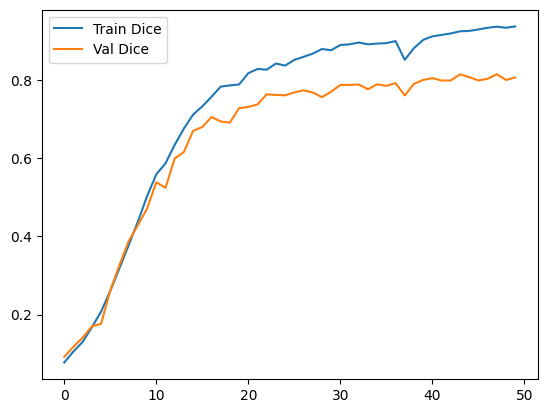

In [ ]:
metrics[['Train Dice','Val Dice']].plot()

<Axes: >

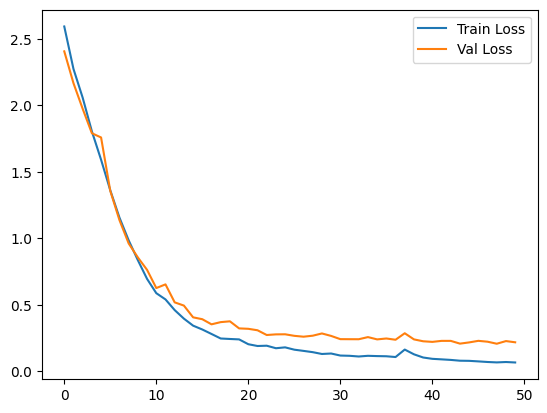

In [ ]:
metrics[['Train Loss','Val Loss']].plot()

In [ ]:
scores = pd.read_csv("/content/drive/MyDrive/CV Project/files/score.csv")
scores.head(10)

Image        F1   Jaccard  Recall  Precision
0   2134  0.049669  0.025467     1.0   0.025467
1   1892  0.050626  0.025970     1.0   0.025970
2    312  0.048914  0.025070     1.0   0.025070
3   2841  0.083519  0.043579     1.0   0.043579
4   1676  0.006328  0.003174     1.0   0.003174
5   1424  0.013940  0.007019     1.0   0.007019
6      3  0.078715  0.040970     1.0   0.040970
7    563  0.042971  0.021957     1.0   0.021957
8   1791  0.005691  0.002853     1.0   0.002853
9    221  0.033281  0.016922     1.0   0.016922

#Watershed implementation for automating segmentation

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

def ShowImage(list_img, list_t, list_cm):
    """
    Display multiple images with corresponding titles and colormaps.

    Args:
        list_img (list): List of images to be displayed.
        list_t (list): List of titles for each image.
        list_cm (list): List of colormaps for each image.
    """
    no_of_img = len(list_img)
    figure, axis_label = plt.subplots(1, no_of_img, figsize = (10*no_of_img, 10))
    for x  in range(no_of_img):
        axis_label[x].imshow(list_img[x], cmap=list_cm[x])
        axis_label[x].axis('off')
        axis_label[x].set_title(list_t[x])
    plt.show()

def watershed(path_img):
    """
    Apply watershed segmentation to an image.

    Args:
        path_img (str): Path to the input image.
    """
    # Read the image
    color_image = cv2.imread(path_img)
    grey_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to obtain a binary image
    computed_threshold, threshold = cv2.threshold(grey_img, 0, 255, cv2.THRESH_OTSU)
    computed_threshold, labeled_image = cv2.connectedComponents(threshold)

    # Find the largest component (presumed to be the brain)
    marker_area = [np.sum(labeled_image == m) for m in range(1, np.max(labeled_image))]
    largest_component = np.argmax(marker_area) + 1
    foreground = labeled_image == largest_component
    brain_out = color_image.copy()
    brain_out[foreground == False] = (0, 0, 0)

    # Apply morphological operations to refine the segmentation
    grey_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    computed_threshold, threshold = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
    background = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    computed_threshold, transform_threshold = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    transform_threshold = np.uint8(transform_threshold)
    unknown = cv2.subtract(background, transform_threshold)
    computed_threshold, labeled_image = cv2.connectedComponents(transform_threshold)
    labeled_image = labeled_image + 1
    labeled_image[unknown == 255] = 0

    # Perform watershed segmentation
    labeled_image = cv2.watershed(color_image, labeled_image)
    color_image[labeled_image == -1] = [255, 0, 0]
    im1 = cv2.cvtColor(color_image, cv2.COLOR_HSV2RGB)

    # Apply morphological closing to refine the brain mask
    foreground = np.uint8(foreground)
    kernel = np.ones((8, 8), np.uint8)
    closing = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

    brain_out = color_image.copy()
    brain_out[closing == False] = (0, 0, 0)

    # Prepare images, titles, and colormaps for visualization
    images = [grey_img, threshold, im1, closing]
    titles = ['Brain MRI', 'Thresholding image', 'Watershed segmented image', 'Closing']
    cmaps = ['gray', 'gray', 'gray', 'gray']

    # Display the images
    ShowImage(images, titles, cmaps)

#DL vs CV

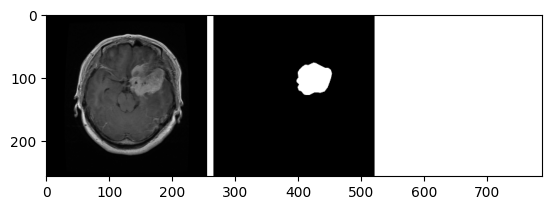

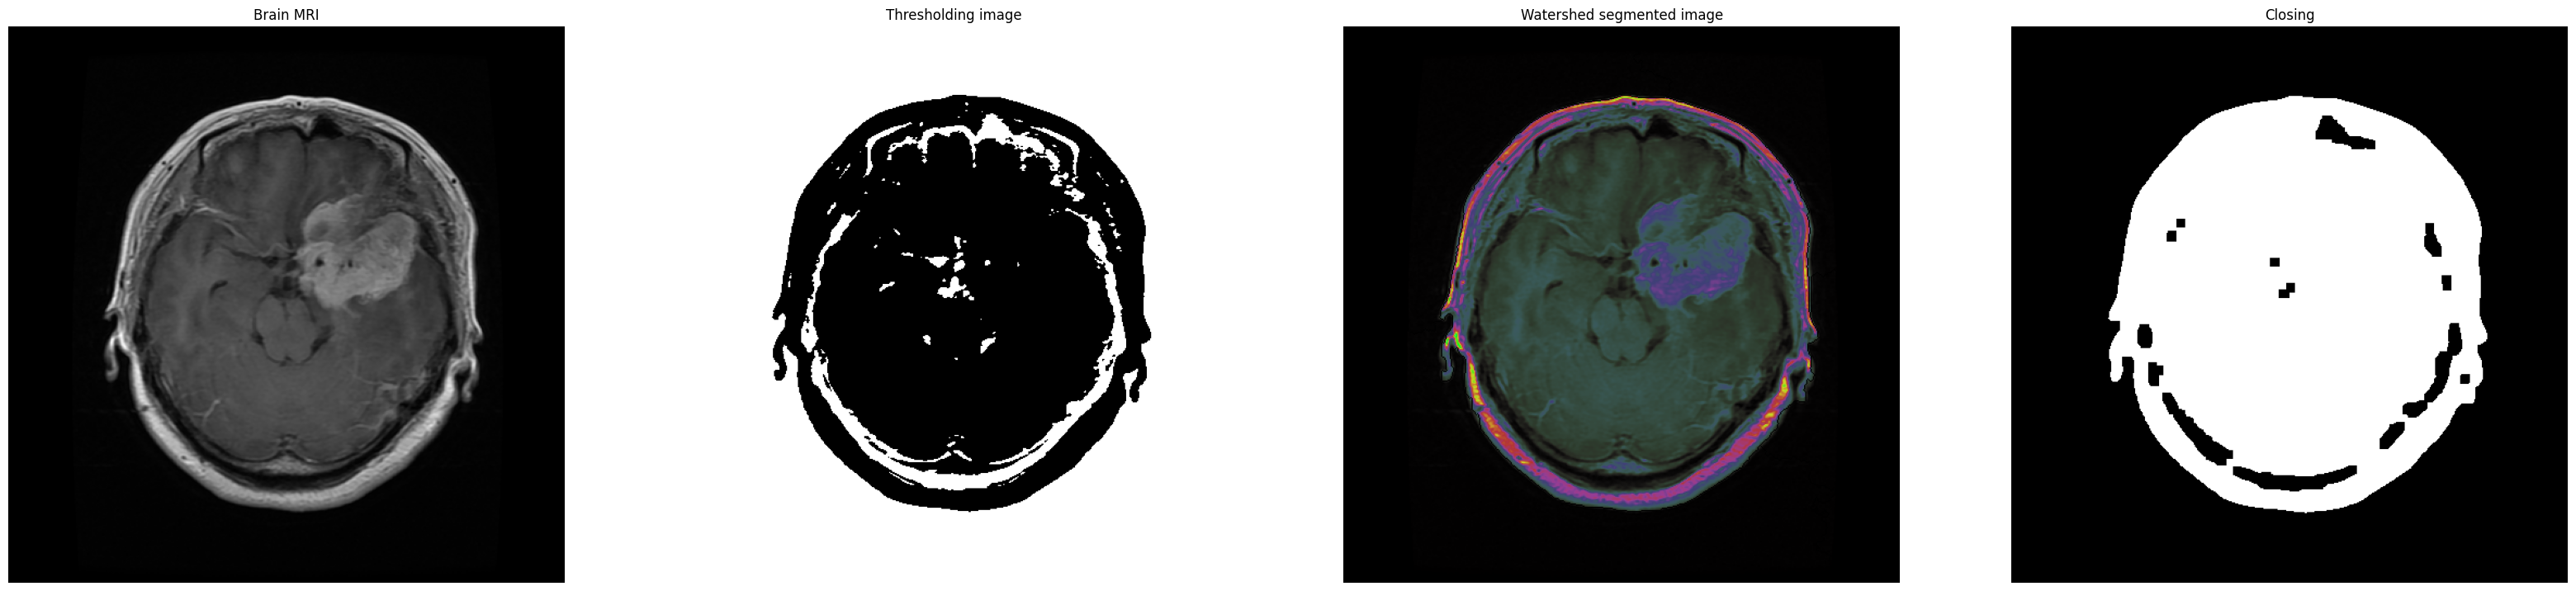

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/CV Project/results/"
images = os.listdir("/content/drive/MyDrive/CV Project/results/")[:15]
a  = "2.png"
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a
print(watershed("/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a))

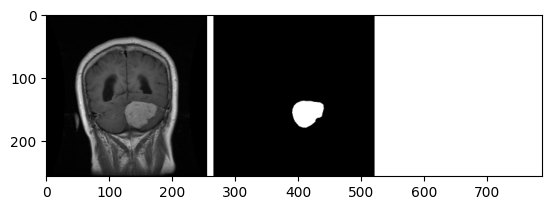

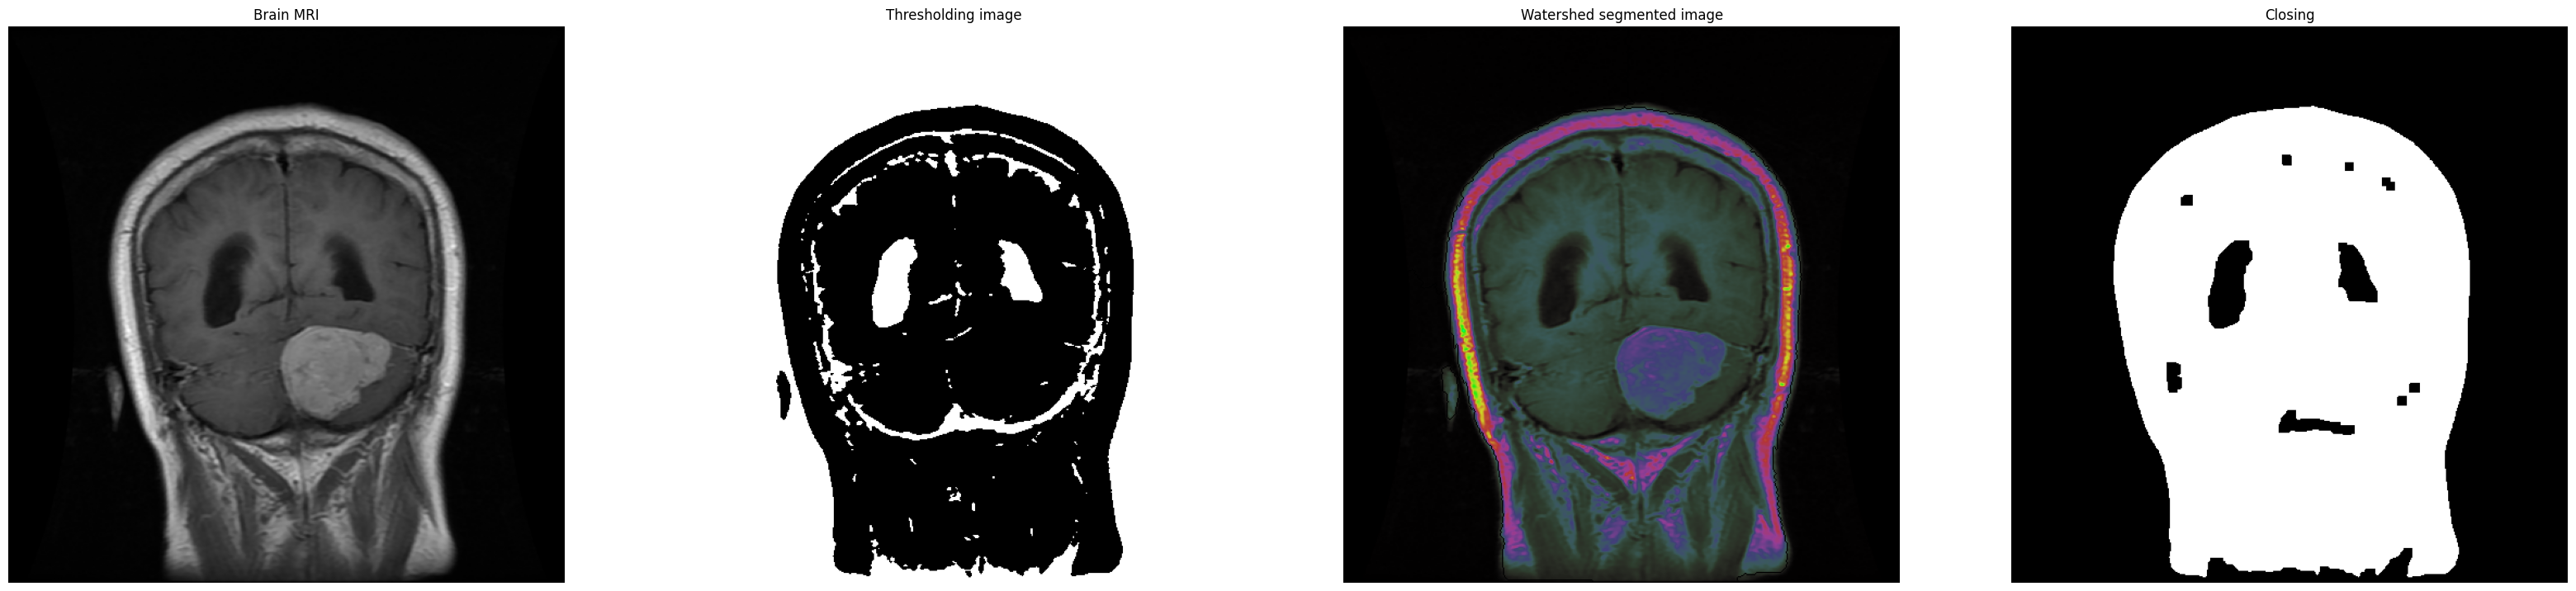

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/CV Project/results/"
images = os.listdir("/content/drive/MyDrive/CV Project/results/")[:15]
a  = images[2]
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a
print(watershed("/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a))

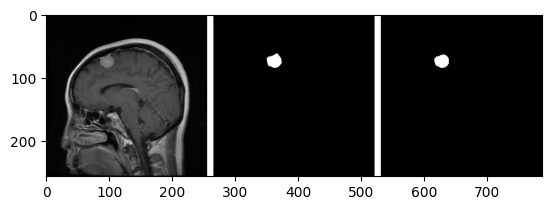

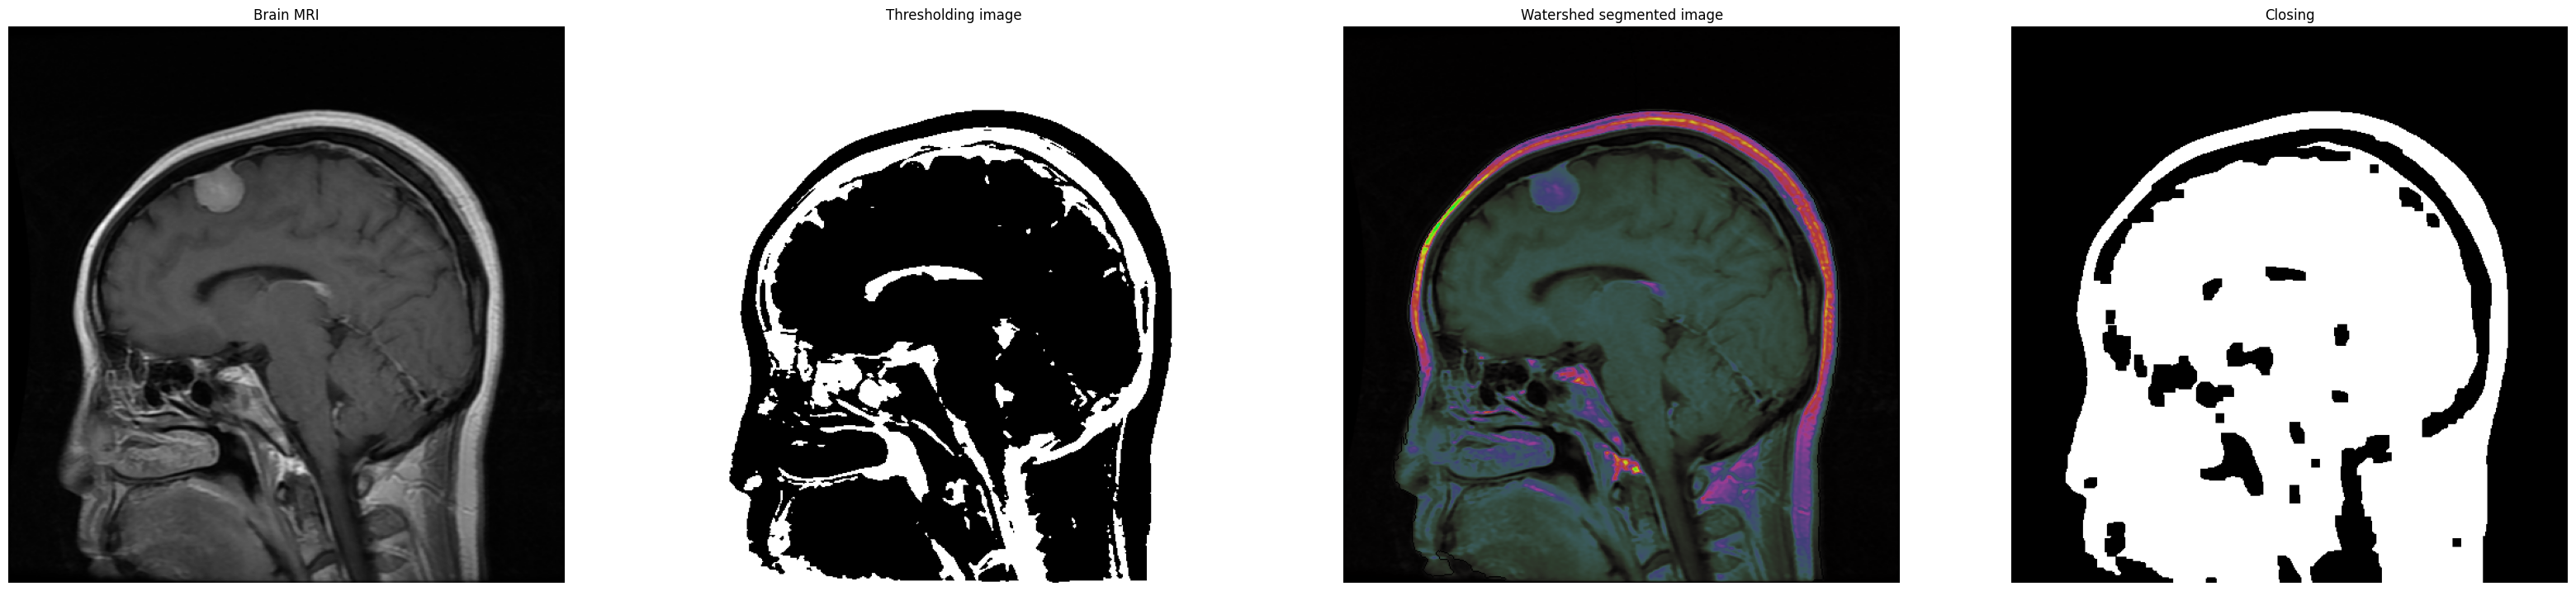

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/CV Project/results/"
images = os.listdir("/content/drive/MyDrive/CV Project/results/")[:15]
a  = images[2]
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a
print(watershed("/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a))

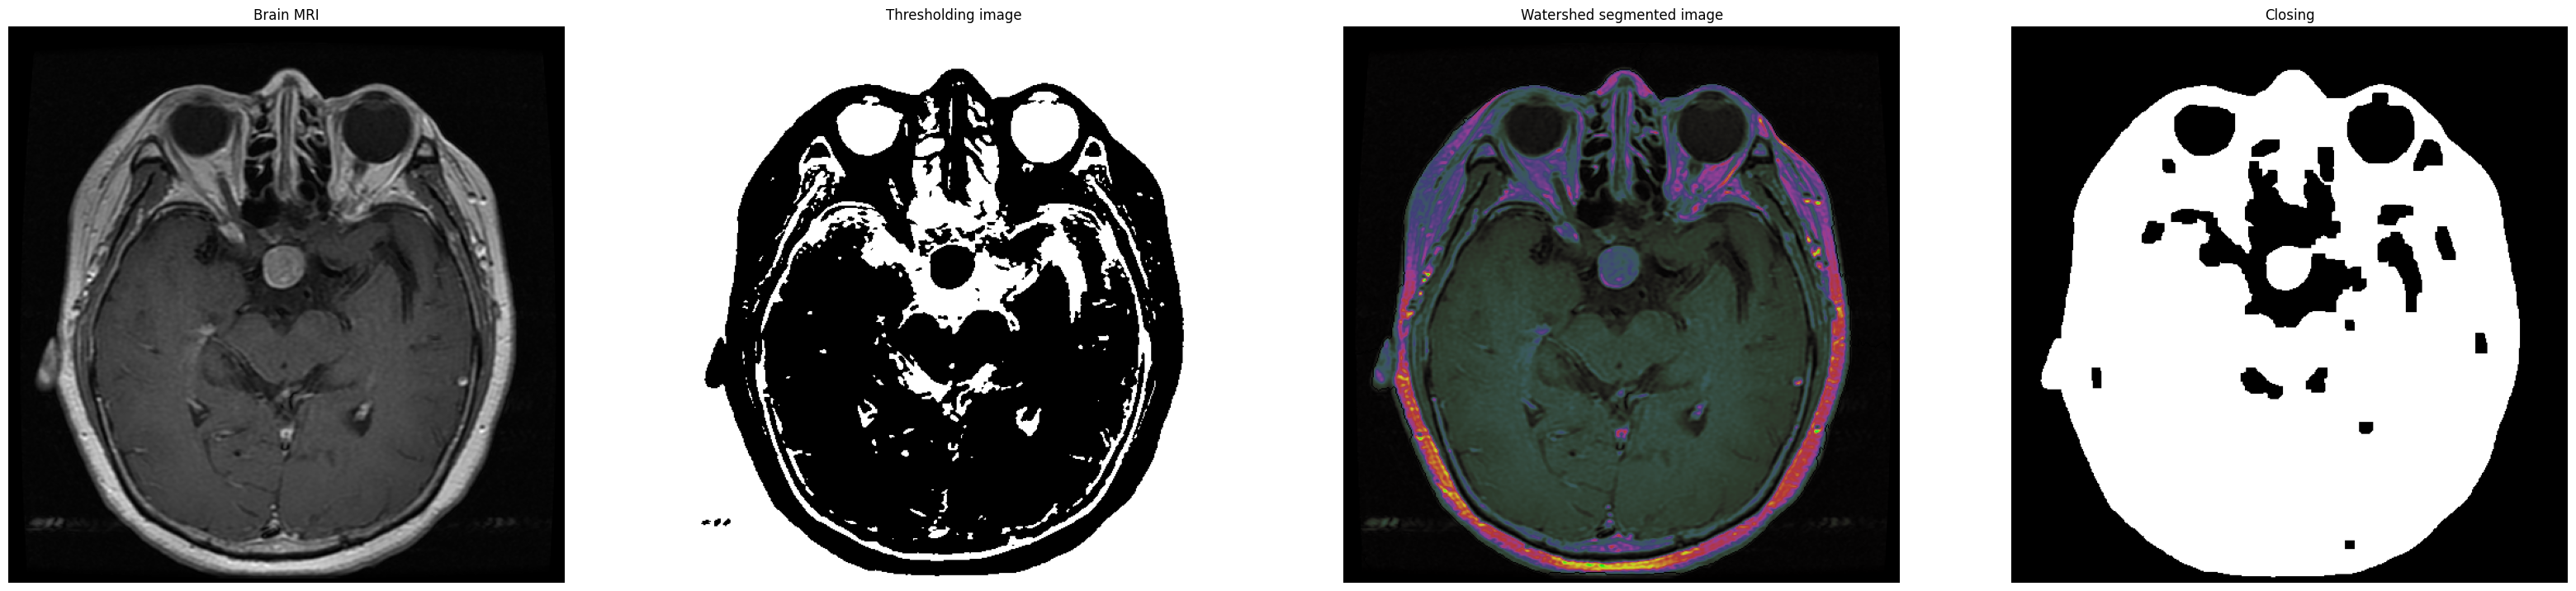

None


In [ ]:
a  = "992.png"
img_path = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a
print(watershed("/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" +a))

##YOLO

###Axial planar

In [ ]:
# Global imports
import zipfile
import urllib.request
from IPython.display import Image, display

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO

In [ ]:
# Download and unzip the dataset

if not os.path.isfile('data.zip'):
  urllib.request.urlretrieve("https://github.com/giuseppebrb/BrainTumorDetection/blob/main/data.zip?raw=true", "data.zip")

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.remove('data.zip')

In [ ]:
model = YOLO('yolov8s.pt')

In [ ]:
import sys
# Train the dataset
model.train(
    data="./data/axial/axial.yaml",
    epochs=400,
    batch=16,
    imgsz=480,
    device="cuda"
)

with open(os.devnull, 'w') as devnull:
    original_stdout = sys.stdout
    sys.stdout = devnull

    print("Model training completed.")
    sys.stdout = original_stdout

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/axial/axial.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

train: Scanning /content/data/axial/labels/training.cache... 364 images, 4 backgrounds, 0 corrupt: 100%|██████████| 367/367 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/axial/labels/validation.cache... 112 images, 14 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      4.72G      1.212      1.491      1.102         28        480: 100%|██████████| 23/23 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        126        123      0.456      0.725      0.513      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      4.72G      1.126      1.147       1.05         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        126        123      0.544      0.656      0.526      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      4.72G       1.15      1.129      1.086         31        480: 100%|██████████| 23/23 [00:04<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        126        123      0.536      0.492      0.462       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      4.72G      1.199      1.223       1.12         23        480: 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        126        123      0.382      0.672       0.45      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      4.72G      1.228      1.219      1.135         34        480: 100%|██████████| 23/23 [00:04<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        126        123      0.722      0.373      0.263      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      4.72G      1.212      1.146      1.099         17        480: 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        126        123      0.424      0.577      0.374      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      4.72G      1.171      1.154      1.114         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        126        123      0.281      0.667      0.334       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      4.72G      1.125      1.042      1.083         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        126        123      0.474      0.651      0.492      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      4.72G      1.151      1.047      1.089         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        126        123      0.484       0.68      0.532      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      4.75G      1.129      1.009      1.094         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        126        123      0.426      0.479      0.388      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      4.75G      1.182      1.034      1.119         20        480: 100%|██████████| 23/23 [00:05<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        126        123      0.396      0.729      0.457      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      4.75G      1.127     0.9789      1.087         21        480: 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        126        123      0.484      0.625      0.455      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      4.75G      1.147       0.99      1.073         30        480: 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        126        123      0.413      0.495      0.386      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      4.75G      1.088      1.005      1.059         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        126        123      0.444      0.502      0.468      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      4.75G      1.104     0.9231      1.088         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        126        123      0.559      0.657      0.592      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      4.75G      1.142      0.912       1.06         41        480: 100%|██████████| 23/23 [00:04<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        126        123      0.539      0.505      0.486      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      4.75G      1.087     0.9106      1.069         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        126        123      0.439      0.589      0.461      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      4.75G      1.094     0.8852       1.06         23        480: 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        126        123      0.393      0.708      0.433      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      4.75G      1.092     0.9182      1.077         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        126        123      0.379      0.625      0.416      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      4.75G      1.062     0.8479      1.046         19        480: 100%|██████████| 23/23 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        126        123      0.381      0.616      0.407      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      4.75G      1.053     0.8122      1.047         20        480: 100%|██████████| 23/23 [00:04<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        126        123      0.429      0.529      0.353      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      4.75G      1.035     0.8594      1.061         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        126        123      0.432      0.569      0.422      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      4.75G       1.04     0.8135      1.039         30        480: 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.334      0.703      0.407      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      4.75G      1.034      0.799      1.031         18        480: 100%|██████████| 23/23 [00:04<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        126        123      0.398      0.731      0.436      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      4.79G       1.06     0.8796       1.06         28        480: 100%|██████████| 23/23 [00:06<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        126        123       0.48      0.594      0.498      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      4.79G      1.022     0.8226      1.048         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        126        123      0.442       0.68      0.474      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      4.79G      1.035     0.9124      1.038         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        126        123      0.523       0.62      0.527      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      4.82G     0.9934     0.8162       1.01         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        126        123      0.469      0.664      0.555      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      4.86G      1.025     0.7966      1.039         22        480: 100%|██████████| 23/23 [00:04<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.548      0.649      0.568      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      4.86G     0.9906     0.8174       1.01         24        480: 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        126        123      0.313      0.636      0.358      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      4.86G      1.014     0.8058      1.026         19        480: 100%|██████████| 23/23 [00:04<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        126        123      0.451      0.762      0.477      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      4.89G      0.991     0.7525      1.017         18        480: 100%|██████████| 23/23 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        126        123      0.369      0.606      0.388      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      4.93G     0.9464      0.706      1.012         31        480: 100%|██████████| 23/23 [00:04<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        126        123      0.397      0.717      0.466      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      4.93G     0.9978     0.7193      1.026         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        126        123      0.399      0.782        0.5      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      4.93G     0.9774     0.7618      1.012         30        480: 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        126        123       0.52      0.753      0.627      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      4.97G      0.995     0.7121      1.022         19        480: 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.447      0.557      0.455       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400         5G      0.937     0.7048      1.003         25        480: 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        126        123      0.456      0.647       0.46      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400         5G     0.9643     0.7051     0.9975         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        126        123       0.41      0.594       0.41      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400         5G     0.9383     0.6814     0.9943         23        480: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        126        123      0.375      0.665      0.434      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      5.04G     0.9797     0.7296      1.025         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        126        123      0.386      0.668      0.445       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      5.04G     0.9647     0.6922     0.9971         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        126        123      0.402       0.59      0.416      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      5.04G     0.9648     0.6864      1.009         23        480: 100%|██████████| 23/23 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        126        123      0.387      0.736      0.419      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      5.04G     0.9229      0.653     0.9811         34        480: 100%|██████████| 23/23 [00:04<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        126        123      0.371      0.697      0.464      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      5.04G     0.9113     0.6491     0.9895         20        480: 100%|██████████| 23/23 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        126        123      0.592      0.542      0.568      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      5.04G     0.8727     0.6036      0.967         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        126        123      0.494      0.788      0.587      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      5.04G     0.9055     0.6416     0.9671         19        480: 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        126        123      0.469      0.701      0.526      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      5.04G     0.9189     0.6475     0.9833         22        480: 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        126        123      0.456      0.664      0.494      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      5.04G     0.9327     0.6274     0.9812         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        126        123      0.447      0.665      0.457      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      5.04G      0.898     0.6902     0.9764         23        480: 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        126        123        0.4      0.669      0.433      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      5.04G      0.885     0.6369     0.9864         20        480: 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        126        123      0.449      0.733      0.527      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      5.04G     0.9088      0.628     0.9817         25        480: 100%|██████████| 23/23 [00:05<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

                   all        126        123      0.553      0.681      0.605       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      5.04G     0.9214     0.6156     0.9808         20        480: 100%|██████████| 23/23 [00:04<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        126        123      0.442      0.644      0.448       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      5.04G     0.8964     0.6092      0.977         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        126        123      0.494      0.683      0.464      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      5.04G     0.9001     0.5874     0.9707         31        480: 100%|██████████| 23/23 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        126        123      0.387      0.623      0.401      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      5.04G     0.8538     0.5616     0.9622         33        480: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        126        123      0.402      0.745      0.449      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      5.04G     0.8996     0.6442     0.9718         19        480: 100%|██████████| 23/23 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        126        123      0.376       0.68      0.371      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      5.04G     0.8361     0.6067     0.9476         15        480: 100%|██████████| 23/23 [00:04<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.407      0.639      0.407      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      5.04G     0.8769     0.5722     0.9686         30        480: 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        126        123      0.469       0.68      0.447      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      5.04G     0.8878     0.6039      0.985         16        480: 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        126        123       0.44      0.511      0.383      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      5.04G     0.8487     0.5592     0.9673         21        480: 100%|██████████| 23/23 [00:04<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


                   all        126        123       0.45      0.596      0.408      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      5.04G     0.8623     0.6058     0.9627         18        480: 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        126        123      0.383      0.641      0.416      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      5.04G     0.8767     0.5872     0.9676         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        126        123      0.458      0.675      0.472      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      5.04G     0.8926     0.5844     0.9826         13        480: 100%|██████████| 23/23 [00:05<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

                   all        126        123      0.529      0.739      0.583      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      5.04G     0.8302     0.5422     0.9393         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        126        123      0.476       0.74      0.526      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      5.04G     0.8292     0.5511     0.9393         24        480: 100%|██████████| 23/23 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        126        123      0.503      0.788      0.567       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      5.04G     0.8698     0.5581     0.9611         28        480: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        126        123      0.529      0.744      0.553      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      5.04G      0.838     0.5713     0.9651         37        480: 100%|██████████| 23/23 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        126        123      0.461      0.693      0.513      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      5.04G     0.8217      0.539     0.9412         21        480: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        126        123      0.521      0.685      0.521      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      5.04G     0.8451     0.5521     0.9601         33        480: 100%|██████████| 23/23 [00:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        126        123      0.525      0.612        0.5      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      5.04G     0.8293     0.5658     0.9509         23        480: 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        126        123      0.425      0.706      0.454      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      5.04G     0.8467     0.5779     0.9686         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all        126        123      0.499      0.676      0.517      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      5.04G     0.8357     0.5655     0.9519         25        480: 100%|██████████| 23/23 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all        126        123      0.446      0.742      0.504      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      5.04G      0.819     0.5463     0.9508         18        480: 100%|██████████| 23/23 [00:04<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        126        123      0.444      0.641      0.444      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      5.04G     0.8618     0.5664     0.9574         25        480: 100%|██████████| 23/23 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        126        123       0.47      0.553      0.437      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      5.04G     0.8144     0.5449     0.9675         31        480: 100%|██████████| 23/23 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        126        123      0.502      0.635      0.472      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      5.04G     0.8229     0.5679     0.9581         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        126        123       0.46       0.62      0.445      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      5.04G     0.8161     0.5412     0.9534         19        480: 100%|██████████| 23/23 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.355      0.681       0.38      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      5.04G     0.7997      0.511     0.9413         23        480: 100%|██████████| 23/23 [00:04<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        126        123      0.417      0.716      0.455      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400      5.04G     0.7591     0.4904     0.9197         21        480: 100%|██████████| 23/23 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all        126        123      0.399      0.742      0.442      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      5.04G      0.766     0.5189     0.9358         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.424      0.635      0.431      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      5.04G     0.8297     0.5498     0.9509         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        126        123      0.517      0.563      0.476      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      5.04G     0.7388     0.4871       0.92         31        480: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        126        123      0.362      0.536      0.354      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      5.04G     0.7715     0.5264     0.9198         30        480: 100%|██████████| 23/23 [00:04<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        126        123      0.569      0.708      0.577      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      5.04G     0.7736      0.521     0.9318         16        480: 100%|██████████| 23/23 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        126        123      0.561      0.671      0.568       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      5.04G     0.7628     0.5183     0.9318         30        480: 100%|██████████| 23/23 [00:04<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        126        123      0.501      0.711      0.528      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      5.04G     0.7829     0.5393     0.9387         27        480: 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        126        123      0.502      0.616      0.482      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      5.04G     0.7565     0.4928     0.9294         37        480: 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        126        123      0.378       0.76      0.442      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      5.04G     0.7562     0.5096     0.9355         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        126        123      0.489      0.672       0.52      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      5.04G     0.7769     0.5098      0.935         23        480: 100%|██████████| 23/23 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        126        123      0.452      0.702      0.465       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      5.04G      0.754     0.5027      0.929         16        480: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all        126        123      0.413      0.604       0.41      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      5.04G     0.7413     0.4895     0.9176         34        480: 100%|██████████| 23/23 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.388      0.614      0.396      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400      5.04G     0.7527     0.4846     0.9309         32        480: 100%|██████████| 23/23 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        126        123      0.464      0.621      0.479       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      5.04G     0.7868     0.5182     0.9435         26        480: 100%|██████████| 23/23 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

                   all        126        123      0.407      0.712      0.466      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      5.04G     0.7367     0.4823      0.915         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        126        123       0.47      0.715      0.501      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      5.04G     0.7576      0.471     0.9242         28        480: 100%|██████████| 23/23 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        126        123      0.508       0.62      0.485      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      5.04G     0.7289     0.4984     0.9176         31        480: 100%|██████████| 23/23 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        126        123      0.443      0.647       0.47      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      5.04G      0.694     0.4565     0.9093         25        480: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


                   all        126        123      0.468      0.635      0.484      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      5.04G     0.7465     0.4811     0.9139         22        480: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        126        123      0.481      0.569      0.482      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      5.04G     0.7072     0.4414     0.9178         17        480: 100%|██████████| 23/23 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        126        123      0.448      0.687      0.494      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      5.04G     0.7452     0.4871     0.9226         34        480: 100%|██████████| 23/23 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        126        123      0.498      0.643      0.478      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      5.04G     0.7183     0.4533     0.9047         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        126        123      0.501       0.72      0.554       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      5.04G     0.7213     0.4635     0.9151         25        480: 100%|██████████| 23/23 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        126        123      0.533      0.629      0.559      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      5.04G      0.725     0.4598     0.9271         26        480: 100%|██████████| 23/23 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        126        123      0.481      0.613      0.466      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      5.04G     0.7257      0.481      0.928         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        126        123       0.55      0.688      0.577      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      5.04G     0.7168     0.4904     0.9205         18        480: 100%|██████████| 23/23 [00:05<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123       0.52      0.658      0.538      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      5.04G     0.7617      0.489     0.9277         32        480: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        126        123      0.486      0.695      0.573      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      5.04G     0.6853     0.4661     0.9016         25        480: 100%|██████████| 23/23 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all        126        123      0.498       0.68      0.511      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      5.04G      0.693     0.4614     0.8967         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        126        123      0.512      0.755      0.579      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      5.04G     0.6889      0.467     0.9114         23        480: 100%|██████████| 23/23 [00:05<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        126        123      0.505      0.736      0.603      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      5.04G     0.6959     0.4626     0.9093         18        480: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.576      0.622      0.559      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      5.04G     0.6598     0.4367     0.8932         21        480: 100%|██████████| 23/23 [00:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        126        123      0.395      0.517      0.365      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      5.04G     0.7049     0.4519     0.9071         22        480: 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        126        123      0.481      0.489      0.397      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      5.04G     0.6607     0.4385     0.8963         30        480: 100%|██████████| 23/23 [00:04<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        126        123      0.461      0.532      0.455      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400      5.04G     0.7159     0.4718     0.9108         31        480: 100%|██████████| 23/23 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        126        123      0.495      0.661      0.484      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      5.04G     0.6994     0.4538     0.9076         20        480: 100%|██████████| 23/23 [00:04<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        126        123      0.484      0.579      0.447      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      5.04G     0.7072     0.4661     0.9196         22        480: 100%|██████████| 23/23 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


                   all        126        123      0.493      0.589      0.466      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      5.04G     0.6841     0.4364     0.8877         27        480: 100%|██████████| 23/23 [00:04<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        126        123       0.58      0.635      0.559      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      5.04G     0.6955     0.4412     0.8898         32        480: 100%|██████████| 23/23 [00:04<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all        126        123      0.425      0.717      0.493      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      5.04G     0.6891     0.4257     0.9077         30        480: 100%|██████████| 23/23 [00:05<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        126        123      0.414      0.715      0.478      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      5.04G     0.6828     0.4375     0.8951         17        480: 100%|██████████| 23/23 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.393      0.693      0.483      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      5.04G     0.6757     0.4523     0.9072         40        480: 100%|██████████| 23/23 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        126        123       0.46      0.613      0.452      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      5.04G     0.7317     0.4628      0.925         17        480: 100%|██████████| 23/23 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        126        123      0.478      0.654      0.465      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400      5.04G      0.667     0.4242     0.8947         27        480: 100%|██████████| 23/23 [00:05<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        126        123      0.441      0.751      0.464      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      5.04G     0.6512     0.4065     0.8833         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.449      0.707      0.492      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      5.04G     0.6727     0.4269     0.9099         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        126        123      0.453      0.715      0.518      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      5.04G     0.7032     0.4585     0.9059         25        480: 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        126        123      0.457      0.592      0.493      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      5.04G     0.6549     0.4298     0.9033         18        480: 100%|██████████| 23/23 [00:04<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        126        123      0.434      0.681       0.47      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      5.04G     0.6552     0.4427      0.897         27        480: 100%|██████████| 23/23 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        126        123      0.476      0.655       0.51       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      5.04G     0.6572     0.4457      0.887         29        480: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        126        123      0.496      0.651      0.522      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      5.04G     0.6297     0.4238     0.8845         19        480: 100%|██████████| 23/23 [00:05<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        126        123      0.418      0.687      0.472      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      5.04G     0.6341     0.4144     0.8771         28        480: 100%|██████████| 23/23 [00:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        126        123      0.435      0.669      0.485      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      5.04G      0.637      0.427     0.8947         30        480: 100%|██████████| 23/23 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        126        123      0.506      0.721      0.572      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      5.04G     0.6584     0.4551     0.9053         18        480: 100%|██████████| 23/23 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        126        123      0.548      0.693      0.569      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      5.04G     0.6728     0.4392     0.9052         24        480: 100%|██████████| 23/23 [00:04<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        126        123      0.467      0.729      0.529      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      5.04G     0.6736     0.4271     0.9048         23        480: 100%|██████████| 23/23 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        126        123       0.48      0.614      0.495      0.353
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



135 epochs completed in 0.232 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


                   all        126        123      0.517      0.753      0.626      0.461
             not tumor         55         56       0.48      0.714      0.657      0.508
                 tumor         57         67      0.554      0.791      0.596      0.414
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
model_1 = YOLO('runs/detect/train3/weights/best_1.pt')

In [ ]:
metrics = model_1.val()

# Extract confusion matrix
conf_matrix = metrics.confusion_matrix

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/data/axial/labels/validation.cache... 112 images, 14 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]


                   all        126        123      0.523      0.753      0.628      0.463
             not tumor         55         56      0.488      0.714      0.661      0.509
                 tumor         57         67      0.558      0.791      0.596      0.417
Speed: 2.2ms preprocess, 5.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2.png: 480x480 1 tumor, 25.0ms
Speed: 5.4ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 480)


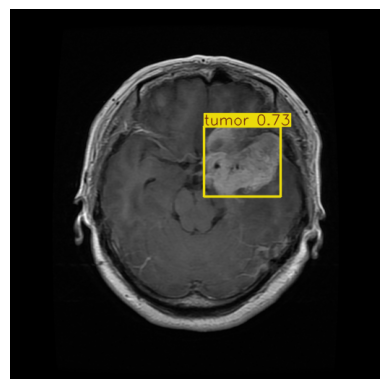

In [ ]:
import matplotlib.pyplot as plt

test_image = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2.png"
results = model_1(test_image)  # Run inference

# Display the image with predictions
res_plotted = results[0].plot()
plt.imshow(res_plotted)  # Convert BGR to RGB
plt.axis("off")
plt.show()


image 1/1 /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/992.png: 480x480 1 tumor, 19.1ms
Speed: 3.3ms preprocess, 19.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 480)


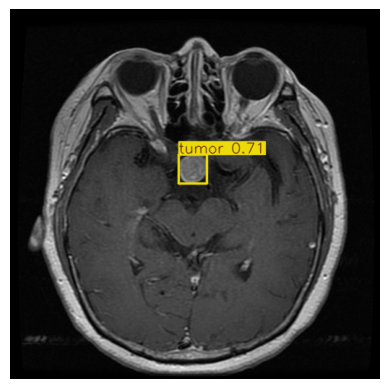

In [ ]:
test_image = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/2.png"
results = model("/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/" + "992.png" )  # Run inference

# Display the image with predictions
res_plotted = results[0].plot()
plt.imshow(res_plotted)  # Convert BGR to RGB
plt.axis("off")
plt.show()

###Coronal planar

In [ ]:
model = YOLO('yolov8s.pt')

In [ ]:
import sys
# Train the dataset
model.train(
    data="./data/coronal/coronal.yaml",
    epochs=400,
    batch=16,
    imgsz=480,
    device="cuda"
)

with open(os.devnull, 'w') as devnull:
    original_stdout = sys.stdout
    sys.stdout = devnull

    print("Model training completed.")
    sys.stdout = original_stdout

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/coronal/coronal.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

train: Scanning /content/data/coronal/labels/training.cache... 318 images, 1 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/coronal/labels/validation.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


Plotting labels to runs/detect/train52/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train52
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      2.69G      1.164      1.635      1.088         18        480: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.457      0.794      0.548       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      2.88G      1.033      1.098      1.031         26        480: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         78         83      0.438      0.818      0.523      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      2.88G      1.078      1.089      1.057         16        480: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         78         83      0.449      0.835      0.519       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      2.88G      1.018      1.044      1.014         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         78         83      0.338      0.721      0.435      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      2.88G      1.007      1.057      1.019         24        480: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         78         83      0.506       0.77      0.561      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      2.88G      1.057      1.056      1.038         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         78         83      0.445      0.894       0.51      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      2.88G      1.018     0.9603      1.034         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.415      0.833      0.559      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      2.88G     0.9572     0.9681     0.9966         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         78         83      0.451      0.724      0.531      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      2.88G     0.9929     0.9302     0.9947         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         78         83      0.454      0.853      0.455      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      2.88G     0.9014     0.8961     0.9637         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         78         83      0.426      0.748      0.498      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      2.88G     0.9851      0.904      1.004         32        480: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

                   all         78         83       0.48      0.736      0.578      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      2.88G     0.9559     0.8676     0.9937         24        480: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         78         83      0.529       0.61       0.56      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      2.88G     0.9391      0.875      1.011         38        480: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         78         83       0.44       0.88      0.573      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      2.88G     0.9752       0.88     0.9933         28        480: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         78         83      0.421      0.693      0.497      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      2.88G     0.9177     0.9321     0.9789         23        480: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         78         83      0.464      0.771      0.538      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      2.88G     0.8661     0.8176     0.9619         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         78         83      0.603      0.615       0.58      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      2.88G     0.9201      0.886     0.9923         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83       0.47      0.704      0.543      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      2.88G     0.9363     0.8221     0.9849         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         78         83       0.44      0.729      0.474      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      2.88G     0.8856     0.8008     0.9616         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         78         83       0.48      0.761      0.549      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      2.88G      0.926     0.8078     0.9983         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.539      0.788      0.574      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      2.88G     0.8749     0.7819     0.9653         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         78         83      0.481      0.789      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      2.88G     0.8884     0.7939     0.9649         35        480: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         78         83      0.537      0.662      0.573      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      2.88G      0.895     0.7382      0.973         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.422      0.717      0.471      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      2.88G     0.8894     0.7828     0.9801         18        480: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         78         83        0.5      0.794      0.634      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      2.88G     0.8195     0.7148     0.9375         24        480: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         78         83      0.559      0.667      0.591      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      2.88G     0.9047     0.7777     0.9764         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         78         83      0.448      0.762      0.498      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      2.88G     0.8936     0.7358     0.9769         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         78         83      0.564      0.718      0.597      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      2.88G      0.848     0.7199     0.9674         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.558      0.705      0.594      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      2.88G     0.8467     0.6911     0.9539         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.556      0.637      0.598      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      2.88G     0.8657     0.7163     0.9578         29        480: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         78         83      0.506      0.651      0.512      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      2.88G     0.8935     0.7618     0.9861         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         78         83      0.514      0.637      0.546      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      2.88G      0.853     0.7141      0.947         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         78         83      0.452      0.751      0.525      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      2.88G     0.8359     0.6836     0.9485         18        480: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.525      0.744      0.556      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      2.88G     0.8228     0.6621      0.957         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.527      0.743      0.608      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      2.88G     0.8395     0.7008     0.9624         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         78         83      0.497      0.744      0.543      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      2.88G     0.8665     0.6966     0.9605         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         78         83      0.544      0.658      0.546      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      2.88G     0.8682     0.7022     0.9573         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

                   all         78         83      0.505      0.755      0.534      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400      2.88G     0.8423     0.6684      0.973         22        480: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         78         83      0.538      0.773      0.589      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      2.88G     0.7836     0.6692     0.9292         17        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         78         83      0.561      0.697      0.559      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      2.88G     0.8548     0.6731     0.9606         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         78         83      0.541      0.776      0.625      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      2.88G     0.8237     0.6684     0.9427         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         78         83      0.535      0.643      0.566      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      2.88G     0.8144     0.6561     0.9407         18        480: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.528      0.738       0.54      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      2.88G     0.8592     0.6503     0.9734         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         78         83      0.406      0.774      0.476      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      2.88G     0.8375     0.7138     0.9498         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         78         83      0.388      0.655      0.464      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      2.88G     0.8405     0.6912     0.9597         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         78         83      0.573      0.699      0.578      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      2.88G     0.8228     0.6722     0.9657         36        480: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         78         83      0.496      0.659      0.571      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      2.88G     0.7624     0.6006     0.9347         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         78         83      0.518      0.722      0.611      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      2.88G     0.7845     0.6185     0.9423         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.558      0.669      0.554      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      2.88G     0.7962     0.5819     0.9294         28        480: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         78         83      0.503      0.656      0.552      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      2.88G     0.8061     0.6193     0.9361         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         78         83      0.452      0.802      0.533      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      2.88G     0.7725     0.5881     0.9332         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         78         83      0.613      0.676      0.629      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      2.88G     0.8335     0.6149     0.9247         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         78         83      0.492      0.729      0.583      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      2.88G     0.7866     0.5848     0.9276         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         78         83      0.483      0.737      0.535      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      2.88G     0.7284     0.5929     0.9168         17        480: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         78         83      0.487      0.737      0.573      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      2.88G      0.796     0.6017     0.9349         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.451      0.778      0.547      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      2.88G     0.8356     0.6023     0.9467         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         78         83      0.418      0.665      0.504      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      2.88G     0.7936     0.6127     0.9295         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         78         83      0.534      0.572      0.567      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      2.88G     0.7832     0.6327     0.9265         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         78         83      0.538      0.738      0.595      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      2.88G     0.7954     0.6164     0.9391         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         78         83      0.521      0.721      0.608      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      2.88G     0.7974     0.6268     0.9471         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         78         83       0.48      0.746      0.541      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      2.88G     0.7372     0.6464      0.914         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.448      0.712      0.456      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      2.88G     0.8398     0.6911     0.9549         19        480: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         78         83      0.449      0.726      0.531      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      2.88G     0.8019     0.6552     0.9459         19        480: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         78         83      0.579      0.633      0.626      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      2.88G     0.8035     0.6275     0.9434         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all         78         83      0.458      0.768      0.552      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      2.88G     0.7579     0.5883     0.9305         24        480: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         78         83      0.546      0.646      0.611       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      2.88G     0.7636     0.5793     0.9262         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         78         83      0.542      0.701      0.634      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      2.88G     0.7372     0.6013     0.9206         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         78         83      0.641      0.599       0.63      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      2.88G     0.7742     0.5684     0.9506         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         78         83      0.548      0.716        0.6      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      2.88G     0.7678     0.5738     0.9327         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.574      0.715      0.599      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      2.88G     0.7602     0.5143      0.917         17        480: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         78         83      0.573      0.638      0.608      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      2.88G     0.7504       0.53     0.9167         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         78         83      0.494      0.768      0.548      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      2.88G     0.7998     0.5663     0.9236         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         78         83      0.527      0.804      0.662      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      2.88G     0.7521     0.5597     0.9398         25        480: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         78         83      0.477      0.679       0.55      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      2.88G     0.7365     0.5455     0.9114         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         78         83      0.531      0.781      0.605      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      2.88G      0.796      0.602     0.9492         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.514      0.811      0.632      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      2.88G     0.7113     0.5395     0.9259         26        480: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         78         83      0.556      0.669      0.584      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      2.88G     0.7824     0.5839     0.9372         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.488      0.574      0.478      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      2.88G     0.7617     0.5683     0.9234         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         78         83      0.424      0.801      0.521      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400      2.88G     0.7587     0.5537     0.9264         39        480: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.541      0.713      0.565      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      2.88G     0.7067      0.511     0.9094         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.505      0.719      0.577      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      2.88G     0.7454     0.5583     0.9241         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         78         83      0.558      0.607      0.624      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      2.88G     0.7179     0.5466      0.918         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83      0.536      0.739      0.551      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      2.88G     0.6979      0.527     0.9104         16        480: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.518      0.785      0.605      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      2.88G     0.6942     0.4844     0.9138         28        480: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         78         83      0.461      0.745      0.547      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      2.88G     0.7067     0.5055     0.9035         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         78         83      0.534      0.667      0.551      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      2.88G     0.6806     0.5166     0.9049         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83       0.58       0.65      0.574      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      2.88G     0.6783      0.495     0.8912         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.609      0.624      0.577      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      2.88G     0.6868     0.5137     0.8855         31        480: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         78         83       0.55      0.734      0.625      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      2.88G     0.7064     0.5071      0.912         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         78         83      0.569       0.67      0.635      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      2.88G     0.7007     0.4991     0.9054         31        480: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         78         83      0.552      0.724      0.642      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400       2.9G     0.7068     0.5251     0.9072         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all         78         83      0.531      0.675      0.607      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400       2.9G     0.7152     0.4816     0.9043         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


                   all         78         83      0.583      0.667      0.619      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400       2.9G     0.7117     0.5259     0.9113         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         78         83      0.549       0.75      0.628      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      2.94G     0.6967     0.5282     0.9062         17        480: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         78         83      0.442      0.785      0.518      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      2.94G     0.7059      0.491     0.9066         27        480: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83      0.524       0.79      0.614      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      2.94G     0.6943     0.4896     0.9032         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all         78         83      0.621      0.661      0.639       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      2.94G     0.7066     0.5209     0.9123         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.581      0.699      0.645      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      2.94G     0.6833     0.5151     0.8878         29        480: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.707       0.61      0.649      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      2.94G     0.6764     0.4892     0.9017         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         78         83      0.587      0.596      0.611      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      2.94G     0.6664     0.4712     0.8988         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         78         83      0.491      0.657      0.569      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      2.94G     0.6869     0.5114     0.9113         33        480: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         78         83      0.616      0.651       0.62      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      2.94G     0.7008     0.5228     0.9201         33        480: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.607      0.661      0.607      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      2.94G     0.7058     0.5277     0.9039         18        480: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         78         83      0.598      0.755      0.667      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      2.94G     0.6811     0.4726     0.8947         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         78         83      0.677      0.646      0.683      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      2.94G      0.649     0.4798     0.8972         15        480: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         78         83      0.625      0.684      0.628      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      2.94G      0.718     0.5108     0.9236         28        480: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         78         83       0.57      0.642      0.584      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      2.94G     0.6816     0.4889     0.9011         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83       0.59      0.582      0.566      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      2.94G      0.654     0.4734     0.8877         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.545      0.641       0.56      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      2.94G     0.6837     0.4859     0.9019         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.468      0.759      0.603      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      2.94G     0.6708     0.4721     0.8921         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         78         83      0.476      0.759      0.589      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      2.94G     0.6202     0.4733     0.8908         29        480: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         78         83      0.539      0.671       0.58      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      2.94G     0.6684     0.4844     0.8977         24        480: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         78         83      0.597      0.674      0.574      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      2.94G     0.6619      0.458     0.8931         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]

                   all         78         83      0.583      0.676      0.636      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400      2.94G     0.6692     0.4528     0.9097         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         78         83      0.597      0.706      0.668      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      2.94G     0.6476     0.4555     0.8835         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.634      0.618      0.652      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      2.94G     0.6503     0.4624     0.8982         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         78         83      0.559      0.699      0.596      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      2.94G     0.6531     0.4552     0.9023         15        480: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         78         83      0.554      0.684      0.599      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      2.94G     0.6528     0.4534     0.8784         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         78         83      0.559       0.66      0.618      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      2.94G     0.6556     0.4429     0.8972         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         78         83      0.652       0.63      0.634      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      2.94G     0.6581     0.4318     0.8989         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         78         83      0.646      0.593      0.616      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      2.94G     0.6633     0.4362     0.8968         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         78         83      0.622      0.604      0.635      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      2.99G     0.7031     0.4881     0.9204         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


                   all         78         83      0.614      0.627      0.601      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400      2.99G     0.6659     0.4649     0.8986         19        480: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.549      0.751      0.626      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      2.99G     0.6321     0.4679     0.8785         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         78         83      0.621      0.654      0.642      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      2.99G     0.6447     0.4685      0.879         18        480: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         78         83      0.499      0.701      0.593       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      2.99G     0.6245     0.4714     0.8822         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         78         83      0.584      0.635      0.594      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      2.99G     0.6621     0.4581     0.8883         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         78         83      0.586      0.614      0.631      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      2.99G     0.6391     0.4589     0.8741         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         78         83      0.599      0.588      0.599      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      2.99G     0.6205     0.4557     0.8786         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         78         83      0.563      0.725      0.648      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      2.99G     0.6179     0.4671      0.877         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         78         83      0.511      0.777      0.602      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      2.99G      0.625     0.4478     0.8892         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         78         83      0.507      0.782      0.595      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      2.99G     0.6351     0.4462     0.8732         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.667      0.612       0.64      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      2.99G     0.5865     0.4226     0.8624         25        480: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         78         83      0.562      0.707      0.646      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      2.99G     0.5961     0.4324     0.8774         30        480: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         78         83      0.549       0.75      0.637      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      2.99G     0.6416      0.461      0.882         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         78         83      0.567      0.653       0.59      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      2.99G     0.5956     0.4226     0.8802         17        480: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         78         83      0.607      0.624      0.598      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400      2.99G     0.6228     0.4309     0.8678         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         78         83      0.543      0.752      0.608      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      2.99G     0.5919     0.3986     0.8636         32        480: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         78         83      0.621      0.645      0.624      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      2.99G     0.5793     0.3997     0.8709         19        480: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         78         83      0.485       0.77      0.564      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      2.99G     0.6207     0.4327     0.8802         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

                   all         78         83      0.553        0.7      0.599      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      2.99G     0.5837     0.4216       0.87         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         78         83        0.6      0.667      0.629       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      2.99G     0.6215      0.424     0.8803         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         78         83       0.55       0.67      0.632      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      2.99G     0.6452     0.4488      0.891         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         78         83      0.668      0.648        0.7      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      2.99G     0.6427     0.4411     0.8862         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83      0.588      0.819      0.689      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      2.99G     0.6254      0.433     0.8811         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         78         83      0.579      0.719      0.622      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      2.99G     0.6117     0.4385      0.877         24        480: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         78         83      0.537      0.702      0.602      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      2.99G     0.5897     0.3975      0.867         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.597      0.669      0.582      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      2.99G     0.5861     0.4284     0.8804         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         78         83      0.587      0.602      0.552      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      2.99G     0.6137        0.4     0.8822         23        480: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         78         83      0.493       0.68      0.597      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      2.99G     0.6138     0.3936     0.8659         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         78         83      0.559      0.778      0.639      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400      2.99G     0.6224     0.4024      0.893         34        480: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

                   all         78         83      0.622      0.664      0.628      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      2.99G     0.5943     0.3879      0.876         24        480: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         78         83      0.657      0.674      0.633      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      2.99G     0.5846     0.3928     0.8614         25        480: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         78         83      0.546      0.721      0.574      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      2.99G     0.5813      0.399      0.873         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         78         83      0.524      0.689       0.58      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      2.99G     0.5471     0.3777     0.8652         18        480: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         78         83      0.476      0.729      0.545      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      2.99G      0.569     0.4217     0.8669         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         78         83      0.494      0.657      0.533      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      2.99G     0.5845      0.425      0.863         18        480: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         78         83      0.578        0.6      0.594      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      2.99G     0.5608     0.4145     0.8631         27        480: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         78         83      0.491      0.722      0.577      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      2.99G     0.5837     0.4145      0.877         30        480: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         78         83      0.589      0.643       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      2.99G     0.5769     0.4029     0.8608         31        480: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all         78         83      0.584      0.599      0.566      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      2.99G     0.5591     0.3707     0.8596         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.586      0.687      0.606       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      2.99G     0.5842     0.3939     0.8751         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         78         83      0.592       0.71      0.614      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      2.99G     0.5445     0.3748     0.8627         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         78         83      0.529      0.667      0.586      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400      2.99G     0.5711     0.3784     0.8457         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         78         83      0.547      0.674       0.58      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      2.99G     0.5716      0.386     0.8727         34        480: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.577      0.752      0.626      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      2.99G     0.5812     0.4091     0.8704         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         78         83      0.506      0.686      0.559       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      2.99G     0.5891     0.4187      0.877         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.522       0.63      0.555       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      2.99G     0.5586     0.4126     0.8581         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         78         83      0.572        0.7      0.621      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      2.99G     0.5913      0.437     0.8696         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         78         83      0.611       0.77      0.669      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400      2.99G     0.5684     0.3948     0.8547         13        480: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         78         83      0.628      0.714      0.656      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      2.99G     0.5832     0.3993     0.8628         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         78         83      0.529      0.755      0.605      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      2.99G     0.5457     0.3736     0.8601         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.529      0.701      0.598      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      2.99G     0.5446       0.38     0.8544         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         78         83      0.503      0.692      0.572      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      2.99G      0.549     0.3959     0.8553         26        480: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         78         83      0.501      0.706      0.581      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      2.99G     0.5407     0.3935     0.8625         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.568      0.706      0.666      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      2.99G     0.5453     0.3842     0.8702         33        480: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         78         83      0.609       0.65       0.68        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      2.99G     0.5603     0.4153     0.8644         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         78         83      0.688      0.644      0.699      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      2.99G     0.5337     0.3811     0.8617         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         78         83      0.548      0.697      0.608      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400      2.99G     0.5416     0.3756     0.8657         23        480: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         78         83      0.629      0.655      0.652      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      2.99G     0.5392     0.3822     0.8701         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         78         83       0.63      0.625      0.652      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      2.99G     0.5346     0.3984     0.8604         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         78         83      0.546      0.711      0.592       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      2.99G     0.5514     0.3807     0.8711         25        480: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         78         83      0.544      0.672      0.587      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400      2.99G     0.5305     0.3649     0.8534         29        480: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.525      0.696       0.61      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      2.99G     0.5356     0.3541     0.8559         28        480: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         78         83      0.569      0.641      0.601      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      2.99G     0.5581     0.3737     0.8805         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         78         83      0.517      0.684      0.577      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      2.99G     0.5458     0.3664     0.8673         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         78         83      0.675      0.579      0.617      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      2.99G     0.5481     0.3618     0.8602         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         78         83      0.622      0.661       0.63      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      2.99G     0.5132     0.3659      0.851         30        480: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.636      0.655       0.59      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      2.99G     0.5351     0.3789     0.8576         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         78         83      0.626      0.696      0.616      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      2.99G     0.5287     0.3722     0.8517         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         78         83      0.665      0.634      0.615      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      2.99G     0.5367     0.3716     0.8556         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         78         83      0.636      0.675      0.623      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400      2.99G     0.5529     0.3863     0.8656         20        480: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         78         83      0.581      0.711      0.617      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      2.99G     0.5041     0.3522     0.8401         33        480: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         78         83      0.528      0.743      0.601      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      2.99G     0.5119     0.3568     0.8457         33        480: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         78         83      0.548        0.7      0.597      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400      2.99G     0.5338     0.3668      0.873         23        480: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         78         83      0.591      0.727      0.607      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      2.99G      0.527     0.3748     0.8526         29        480: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         78         83      0.619      0.725       0.68      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      2.99G     0.5314     0.3709     0.8626         34        480: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         78         83      0.616      0.706      0.652       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      2.99G     0.5334     0.3777     0.8632         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         78         83      0.557      0.742      0.602      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      2.99G     0.5098     0.3694     0.8614         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         78         83       0.52      0.745      0.594      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400      2.99G     0.5207     0.3436     0.8449         24        480: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         78         83      0.545       0.72       0.61      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      2.99G      0.486     0.3636     0.8464         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         78         83      0.599       0.69      0.654      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      2.99G     0.4823     0.3385     0.8422         33        480: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         78         83      0.537      0.754      0.606      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      2.99G     0.5221     0.3602     0.8527         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all         78         83      0.534       0.74      0.624      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      2.99G     0.5143     0.3529     0.8377         25        480: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

                   all         78         83       0.61      0.687      0.659      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400      2.99G     0.5245     0.3666     0.8492         29        480: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         78         83      0.682      0.632      0.628      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      2.99G     0.5004     0.3611     0.8569         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         78         83      0.566      0.665      0.578      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400      2.99G     0.4892     0.3639     0.8435         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         78         83      0.553      0.755      0.596      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      2.99G     0.5131     0.3627     0.8556         20        480: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         78         83      0.612      0.722      0.619      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      2.99G     0.5341     0.3594     0.8764         31        480: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         78         83      0.647      0.711       0.66      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      2.99G     0.5456     0.4149     0.8637         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         78         83      0.572      0.676       0.65      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      2.99G     0.4928     0.3421     0.8428         25        480: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         78         83      0.568      0.742      0.616      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      2.99G     0.4927     0.3819     0.8538         14        480: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         78         83      0.587      0.539      0.547      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      2.99G     0.5079     0.3571     0.8502         32        480: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         78         83      0.568      0.612      0.578      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      2.99G     0.5047     0.3523     0.8499         22        480: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         78         83      0.588       0.63      0.608      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400      2.99G     0.5027     0.3555     0.8439         20        480: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         78         83      0.618       0.69       0.61       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      2.99G     0.4836     0.3405     0.8438         17        480: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all         78         83      0.652      0.685      0.649      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      2.99G     0.5058     0.3488     0.8443         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.661      0.652      0.634      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      2.99G     0.5174     0.3633      0.863         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         78         83      0.557      0.748      0.629      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400      2.99G     0.4868     0.3312      0.847         26        480: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

                   all         78         83      0.606      0.763      0.645      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      2.99G     0.4809     0.3345     0.8432         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         78         83      0.607      0.744      0.689      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      2.99G     0.5036     0.3279     0.8522         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         78         83      0.596      0.755      0.655      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      2.99G     0.5113     0.3481     0.8499         28        480: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         78         83      0.549      0.763      0.602       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400      2.99G     0.4756     0.3334     0.8441         17        480: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         78         83      0.555       0.73      0.616      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      2.99G     0.4863     0.3377     0.8432         28        480: 100%|██████████| 20/20 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.538      0.748       0.63      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400      2.99G     0.4679     0.3332     0.8453         21        480: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         78         83      0.583      0.713      0.657      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      2.99G     0.5042     0.3427      0.853         18        480: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         78         83      0.593      0.734      0.654      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      2.99G     0.4864     0.3297     0.8465         27        480: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         78         83      0.543      0.699      0.606      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      2.99G     0.4617      0.332     0.8259         19        480: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         78         83      0.598      0.578      0.588      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      2.99G     0.5006     0.3558     0.8463         18        480: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         78         83      0.586      0.714      0.645      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      2.99G     0.4875     0.3395     0.8541         25        480: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         78         83       0.56      0.713       0.62      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      2.99G     0.4588     0.3254     0.8338         24        480: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         78         83      0.565        0.7      0.595       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400      2.99G     0.5064     0.3488      0.855         34        480: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         78         83      0.532      0.681      0.591      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400      2.99G     0.4968     0.3501     0.8492         34        480: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         78         83      0.648      0.621      0.631      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      2.99G     0.4678      0.327     0.8383         27        480: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         78         83       0.62      0.649      0.623      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400      2.99G     0.4774     0.3172     0.8428         22        480: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         78         83      0.619      0.694      0.626      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      2.99G     0.4732     0.3458     0.8507         26        480: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         78         83      0.609      0.734      0.609      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      2.99G     0.4646     0.3244     0.8535         21        480: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

                   all         78         83      0.578      0.746      0.637      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400      2.99G     0.4497     0.3241     0.8313         34        480: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         78         83      0.537      0.732      0.629      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400      2.99G     0.4891     0.3532      0.852         16        480: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         78         83      0.616      0.672      0.658       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      2.99G     0.4886     0.3371     0.8638         22        480: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         78         83      0.645      0.685      0.636      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      2.99G     0.4915     0.3389     0.8496         23        480: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         78         83      0.554      0.734      0.609      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      2.99G     0.4504     0.3234     0.8371         17        480: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         78         83      0.681      0.671      0.646      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400      2.99G     0.4611     0.3225     0.8376         20        480: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         78         83      0.657      0.686      0.633      0.469
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 143, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



243 epochs completed in 0.363 hours.
Optimizer stripped from runs/detect/train52/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train52/weights/best.pt, 22.5MB

Validating runs/detect/train52/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


                   all         78         83      0.668      0.652      0.699      0.527
             not tumor         32         34      0.637      0.735       0.68      0.538
                 tumor         46         49      0.699      0.568      0.718      0.516
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train52


In [ ]:
model_2 = YOLO('runs/detect/train52/weights/best_2.pt')

In [ ]:
metrics = model_2.val()

# Extract confusion matrix
conf_matrix = metrics.confusion_matrix

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/data/coronal/labels/validation.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


                   all         78         83      0.668      0.648      0.698      0.525
             not tumor         32         34      0.641      0.734      0.679      0.533
                 tumor         46         49      0.696      0.561      0.717      0.517
Speed: 1.1ms preprocess, 7.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val4



image 1/1 /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/401.png: 480x480 1 tumor, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 480)


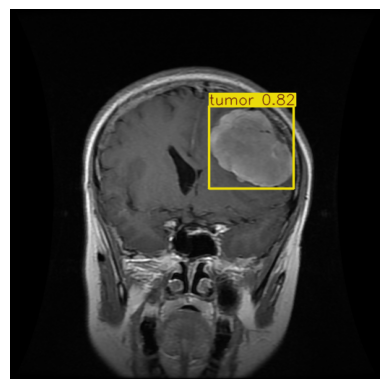

In [ ]:
import matplotlib.pyplot as plt

test_image = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/401.png"
results = model_2(test_image)  # Run inference

# Display the image with predictions
res_plotted = results[0].plot()
plt.imshow(res_plotted)  # Convert BGR to RGB
plt.axis("off")
plt.show()

###Sagittal planar

In [ ]:
model = YOLO('yolov8s.pt')

In [ ]:
import sys
# Train the dataset
model.train(
    data="./data/sagittal/sagittal.yaml",
    epochs=400,
    batch=16,
    imgsz=640,
    device="cuda"
)

with open(os.devnull, 'w') as devnull:
    original_stdout = sys.stdout
    sys.stdout = devnull

    print("Model training completed.")
    sys.stdout = original_stdout

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/sagittal/sagittal.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train522, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

train: Scanning /content/data/sagittal/labels/training.cache... 264 images, 0 backgrounds, 0 corrupt: 100%|██████████| 264/264 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/sagittal/labels/validation.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs/detect/train522/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train522
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      4.47G      1.059      1.339      1.195          6        640: 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         70         77      0.379      0.616      0.395      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      5.22G      1.055      1.289      1.124         18        640: 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


                   all         70         77      0.367      0.704      0.412      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      5.22G      1.006       1.05      1.141         10        640: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         70         77      0.416      0.548      0.399      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      5.22G     0.9779      1.029      1.116         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         70         77      0.364      0.752      0.437      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      5.22G     0.9847     0.9818      1.088          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.393      0.559      0.372      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      5.22G     0.9342      1.007      1.072         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         70         77      0.324      0.743      0.433      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      5.22G     0.8981     0.8966      1.025         12        640: 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77      0.412      0.677      0.497       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      5.22G     0.9107      0.867       1.05         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         70         77      0.426      0.858      0.521      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      5.22G     0.9478     0.8995      1.082         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.367      0.717      0.493      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      5.22G     0.9019     0.8011      1.038         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         70         77      0.463      0.691      0.476       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      5.22G     0.9351     0.8206      1.026         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         70         77       0.37      0.692      0.421      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      5.22G     0.9042     0.8382      1.042         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         70         77      0.401      0.614      0.419      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      5.22G     0.8554      0.753      1.021         15        640: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         70         77      0.384      0.666      0.444      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      5.22G     0.8952     0.7603      1.038         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         70         77       0.42       0.56      0.432       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      5.22G     0.8841     0.7419       1.03         18        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         70         77      0.356      0.621      0.454      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      5.22G     0.8814     0.7653      1.015         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         70         77      0.401      0.794      0.474       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      5.22G     0.8664     0.7565      1.021         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         70         77      0.368      0.628      0.461      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      5.22G     0.7905     0.6831     0.9865         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         70         77      0.434      0.586      0.467      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      5.22G     0.8085     0.6513     0.9915         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         70         77      0.383       0.76      0.449      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      5.22G     0.8609     0.7337      1.031         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         70         77      0.406      0.727      0.461      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      5.22G     0.8084     0.6391     0.9986         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

                   all         70         77      0.416      0.689      0.507       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      5.22G     0.8221     0.6886      1.015          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         70         77      0.431      0.568      0.422       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      5.22G     0.8412     0.7363      1.008         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         70         77      0.338      0.551      0.377       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      5.22G      0.804     0.6729     0.9933         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         70         77      0.359      0.746      0.437      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      5.22G     0.7896     0.6347     0.9951         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         70         77      0.352      0.733      0.405      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      5.22G     0.7947     0.6768     0.9976         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         70         77      0.432      0.737      0.502      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      5.23G     0.8041     0.6332     0.9818         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         70         77      0.419       0.78      0.487      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      5.26G     0.7316     0.6113     0.9452         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         70         77      0.334      0.651      0.383      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      5.26G     0.7977     0.6048     0.9887         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         70         77      0.387       0.78      0.456      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400       5.3G     0.8162     0.6797       1.01         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         70         77      0.352      0.816      0.503      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400       5.3G     0.7476     0.5614     0.9485         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         70         77      0.429      0.492      0.435      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      5.33G      0.767     0.6321     0.9772         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         70         77      0.417       0.78      0.471      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      5.33G     0.7675     0.5959     0.9746         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         70         77      0.408      0.741      0.486       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      5.33G     0.7294      0.544     0.9588         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         70         77       0.41      0.683      0.471      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      5.34G     0.7501     0.5485     0.9485         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         70         77      0.487      0.747      0.558      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      5.34G     0.7811     0.5963     0.9825          4        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         70         77      0.461      0.573      0.479      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      5.34G     0.7789     0.6172     0.9823         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         70         77      0.405      0.592      0.454      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400      5.34G     0.7352     0.5593     0.9504         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         70         77      0.379       0.69      0.423      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      5.34G     0.7497     0.5552     0.9478         17        640: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         70         77      0.271      0.949      0.475      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      5.34G     0.7592     0.6131      0.982         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         70         77      0.387      0.627      0.462      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      5.34G     0.7328      0.546     0.9519         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         70         77      0.348      0.678       0.38      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      5.34G     0.7409     0.5785     0.9666         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         70         77      0.365      0.652      0.421        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      5.34G     0.7423     0.5575      0.984         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


                   all         70         77      0.385      0.714      0.448      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      5.34G     0.8004     0.6002      1.001          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         70         77       0.39      0.586      0.436      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      5.34G     0.7413      0.543     0.9679         16        640: 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         70         77      0.396      0.649      0.454       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      5.34G     0.7019     0.5326     0.9462          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         70         77      0.328      0.642      0.387      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      5.34G     0.7141     0.5435     0.9456          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         70         77      0.392      0.532      0.408      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      5.34G     0.7495     0.5349     0.9689         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         70         77      0.411      0.689      0.485       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      5.34G     0.7269     0.5221     0.9443         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         70         77      0.391       0.69      0.453      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      5.34G     0.7354     0.5444     0.9798          8        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         70         77      0.412      0.684       0.49      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      5.34G     0.7392     0.5335     0.9513         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         70         77      0.423      0.626      0.512      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      5.34G     0.7027     0.5509     0.9417         12        640: 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         70         77      0.366      0.627      0.452      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      5.34G     0.6719     0.4934     0.9373         18        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         70         77      0.494      0.484      0.456      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      5.34G     0.7248     0.5234     0.9794          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         70         77      0.496      0.549      0.505      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      5.34G     0.6909     0.5351     0.9596         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         70         77      0.461      0.585      0.474      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      5.34G     0.7243     0.6162      0.949         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         70         77      0.486      0.571      0.467      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      5.34G     0.7241     0.5745     0.9495         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         70         77      0.422      0.663      0.456      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      5.34G     0.7068     0.5087     0.9372         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         70         77      0.416      0.611      0.475      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      5.34G     0.7307     0.5554     0.9582         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.447      0.519      0.421      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      5.34G     0.7135     0.5475     0.9482         21        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         70         77      0.347      0.612       0.39      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      5.34G     0.6686     0.4917     0.9524         10        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         70         77      0.408      0.599      0.448      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      5.34G     0.6838     0.5108     0.9334         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         70         77      0.365      0.685      0.406      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      5.34G     0.6633     0.4895     0.9462         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         70         77      0.387      0.716      0.432      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      5.34G     0.6939     0.5194     0.9516         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         70         77      0.404      0.614      0.482      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      5.34G     0.6876     0.5304     0.9376         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         70         77       0.44      0.596      0.508      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      5.34G     0.6603      0.509     0.9554         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         70         77      0.357      0.935       0.49       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      5.34G     0.6251     0.4485     0.9167         18        640: 100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         70         77      0.391      0.705      0.509       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      5.34G     0.6634     0.5157     0.9153         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.352      0.936      0.478      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      5.34G      0.666     0.5205     0.9289         18        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70         77       0.33      0.884      0.465      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      5.34G     0.6616     0.4748     0.9312         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         70         77      0.414      0.691      0.557      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      5.34G     0.6515     0.4593     0.9521         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         70         77      0.433      0.653       0.48      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      5.34G     0.6703      0.484      0.939          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         70         77        0.4      0.678      0.483      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      5.34G     0.6402     0.4593     0.9207         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         70         77      0.494      0.588      0.538      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      5.34G      0.665     0.4714     0.9436         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         70         77      0.528      0.556       0.48      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      5.34G     0.6347     0.4861     0.9215         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         70         77       0.38      0.686      0.438      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      5.34G     0.6479     0.4767     0.9158         16        640: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         70         77      0.474       0.55      0.488      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      5.34G     0.6805     0.4839       0.92          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         70         77      0.406      0.648      0.482      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      5.34G     0.6713     0.4899     0.9492         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         70         77       0.39      0.698      0.436      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400      5.34G     0.6719     0.5121     0.9387          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         70         77      0.443      0.721       0.51       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      5.34G     0.6664      0.512     0.9493         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         70         77        0.4      0.715      0.453      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      5.34G     0.6653     0.4744     0.9451         19        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         70         77      0.474      0.521      0.453      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      5.34G     0.6424     0.4835      0.937         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         70         77      0.489      0.559      0.553      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      5.34G     0.6478     0.5052      0.935         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         70         77      0.425      0.612      0.507      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      5.34G     0.6403     0.5044     0.9175         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         70         77      0.494      0.466      0.465      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      5.34G     0.6242      0.458     0.9106         13        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         70         77      0.508      0.479      0.469      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      5.34G      0.613     0.4435     0.8955          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         70         77      0.623      0.463      0.497      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      5.34G     0.6268     0.4697     0.9289         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         70         77      0.392      0.628      0.443      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      5.34G     0.6147     0.4731      0.913         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         70         77      0.421      0.663      0.455       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      5.34G     0.6194       0.46     0.9056          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         70         77      0.378      0.626      0.439      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      5.34G     0.6279     0.4519      0.932          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         70         77      0.368      0.587      0.463      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      5.34G     0.6199     0.4551     0.9097          6        640: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         70         77      0.445      0.665       0.47      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400      5.34G     0.6115     0.4555     0.9178          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         70         77      0.441       0.64      0.462      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      5.34G     0.6403      0.489     0.9433          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         70         77      0.501      0.535      0.474      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      5.34G     0.5913     0.4671     0.9032         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         70         77      0.386      0.576        0.4      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      5.34G      0.603     0.4658      0.903          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         70         77      0.386      0.668      0.442      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      5.34G     0.6007     0.4408     0.9081         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         70         77      0.458      0.561      0.482      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      5.34G     0.6083     0.4282     0.9187         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         70         77      0.412      0.586      0.501      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      5.34G     0.6036     0.4416      0.905         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         70         77      0.436       0.59      0.471      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      5.34G     0.5867     0.4393     0.9092         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         70         77      0.372        0.6      0.402      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      5.34G     0.6364     0.4638     0.9318         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         70         77      0.449      0.547      0.445      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      5.34G     0.5944     0.4285     0.9123         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         70         77      0.421      0.678      0.508      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      5.34G     0.5963     0.4586      0.916         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         70         77       0.41      0.664      0.457      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      5.34G     0.5683     0.4151     0.8903         18        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         70         77       0.43       0.64      0.517       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      5.34G     0.5798     0.4181     0.9043         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         70         77      0.498      0.666       0.55      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      5.34G     0.5418     0.3879     0.8747         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77      0.392      0.635      0.486      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      5.34G     0.5355     0.4114     0.8899         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         70         77      0.426      0.656      0.511      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      5.34G     0.5753     0.4234     0.8972         13        640: 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         70         77      0.433      0.729      0.521      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      5.34G     0.5549      0.394     0.8869         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         70         77      0.506      0.573      0.496      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      5.34G       0.57     0.3984     0.8985          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         70         77       0.31       0.91      0.494      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      5.34G     0.5888     0.4167     0.8863         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         70         77      0.432      0.612      0.486      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      5.34G     0.6239     0.4359     0.9205         19        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         70         77      0.403      0.677       0.51      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      5.34G     0.5514      0.441     0.8884         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         70         77      0.294      0.858       0.45      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      5.34G     0.6367     0.4436     0.9207         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         70         77      0.428      0.641      0.487       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400      5.34G     0.6185      0.456     0.9218         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         70         77      0.458      0.626      0.432      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      5.34G     0.6078     0.4304     0.9046          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         70         77      0.433      0.654      0.484      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      5.34G     0.5769     0.4098     0.8906         23        640: 100%|██████████| 17/17 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         70         77      0.529      0.587      0.543        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      5.34G     0.5383     0.3886     0.9018         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         70         77      0.405      0.729      0.559      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      5.34G      0.634     0.4351     0.9367         18        640: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         70         77      0.437      0.638      0.495      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      5.34G     0.5567     0.4096     0.8782         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         70         77      0.441      0.667       0.49      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      5.34G     0.5485     0.4149     0.8946         12        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         70         77      0.455      0.634       0.51      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      5.34G     0.5461     0.3829     0.8864         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         70         77      0.434      0.588       0.47      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      5.34G      0.549     0.3982     0.8947         13        640: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         70         77      0.435      0.592      0.467       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400      5.34G     0.5976     0.4214     0.9085         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         70         77       0.41      0.637      0.477      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      5.34G     0.5717     0.4415     0.9063         18        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         70         77        0.4       0.64      0.423      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      5.34G     0.5312     0.3955     0.8786          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         70         77      0.364        0.6      0.428      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      5.34G     0.5698     0.4038     0.9077         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         70         77      0.435      0.665      0.498      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      5.37G     0.5335     0.3855     0.8875         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         70         77      0.445      0.655      0.476      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      5.37G     0.5345     0.3829     0.9003         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         70         77      0.392      0.768       0.45      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      5.41G     0.5742     0.4102     0.9125          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         70         77      0.394      0.598      0.439      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      5.41G     0.5433     0.4074     0.8884         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         70         77      0.312      0.909      0.429      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      5.41G     0.5575     0.3895     0.8989         11        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         70         77      0.337      0.858      0.461      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      5.41G     0.5296      0.371     0.8708         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         70         77      0.397       0.65      0.482      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      5.41G     0.5574     0.3972     0.8968         14        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         70         77      0.326      0.782      0.411      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      5.41G     0.5418     0.3884      0.897         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         70         77      0.331      0.756       0.44      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      5.41G      0.494     0.3841     0.8698          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         70         77      0.429      0.688      0.498      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      5.41G     0.5494     0.4239     0.9075          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         70         77      0.452        0.7      0.508       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400      5.41G     0.4859     0.3658     0.8451         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         70         77      0.492      0.636      0.524      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      5.41G     0.5626     0.4114     0.9139         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         70         77      0.458      0.627      0.514      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      5.41G     0.5406     0.4292     0.8903         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         70         77      0.429      0.607       0.47       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      5.41G     0.5094     0.3792     0.8774          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         70         77      0.453      0.652      0.466      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      5.41G     0.5343     0.4023     0.8954         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         70         77      0.443      0.637      0.467      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      5.41G     0.5299     0.4139     0.8975         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         70         77      0.423      0.651      0.471      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      5.41G     0.5446     0.4202     0.8981         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         70         77        0.4      0.614      0.505      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      5.41G     0.5525      0.411     0.9046          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         70         77       0.44      0.703      0.564      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      5.41G     0.5271     0.4048     0.8889         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         70         77      0.484       0.56      0.523      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      5.41G     0.5569     0.4259     0.9175         13        640: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         70         77      0.458      0.664      0.504      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      5.41G     0.5197     0.4251     0.8779         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         70         77      0.426       0.69      0.541      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      5.41G     0.5088     0.3856     0.8541         15        640: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         70         77      0.435      0.562      0.499      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      5.41G     0.5286      0.386     0.8722          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         70         77      0.453      0.672      0.469      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      5.41G     0.5273     0.3872     0.8908         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         70         77      0.448      0.747      0.548      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400      5.41G     0.5301     0.3831      0.907         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         70         77      0.373      0.897      0.514      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      5.41G     0.4971     0.3693     0.8702         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         70         77       0.36      0.897      0.492       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      5.41G     0.5116     0.3844     0.8699         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77      0.385      0.859      0.521      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      5.41G     0.5481     0.3873     0.8927         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         70         77      0.385      0.858      0.528      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      5.41G     0.4883     0.3698     0.8675          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         70         77      0.427      0.612      0.484      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      5.41G     0.5606     0.3921     0.8779         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         70         77       0.44        0.6      0.486      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      5.41G     0.5074     0.3638     0.8995          9        640: 100%|██████████| 17/17 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         70         77      0.449      0.588      0.463      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      5.41G     0.5201     0.3649     0.8732          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         70         77      0.413      0.667      0.476      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      5.41G     0.5334     0.3741     0.8846          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         70         77      0.468      0.587      0.488      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      5.41G     0.5217     0.3848     0.9005         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.406      0.626      0.471      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      5.41G     0.5136     0.3903     0.8768         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         70         77      0.415      0.685      0.504      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      5.41G     0.4984     0.3615     0.8761         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         70         77      0.416      0.651      0.492       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      5.41G     0.5256     0.3875     0.8898         17        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         70         77      0.435      0.621      0.494      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400      5.41G     0.5009     0.3669     0.8612         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         70         77      0.407      0.662      0.482      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      5.41G     0.5186     0.4138     0.8734         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         70         77      0.419      0.651      0.491      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      5.41G     0.5001     0.3628     0.8635         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         70         77      0.379       0.64      0.442      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      5.41G     0.5279     0.3579     0.8825         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         70         77      0.447      0.552      0.446      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      5.41G     0.5672     0.3998     0.9063         11        640: 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         70         77      0.445      0.588      0.474      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      5.41G     0.5467     0.4025     0.8994          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         70         77      0.486      0.599      0.525      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400      5.41G     0.5124     0.3637     0.8807         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         70         77      0.502      0.608      0.522      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      5.41G     0.5035     0.3739     0.8782         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         70         77      0.471      0.626      0.501      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      5.41G     0.4627      0.355     0.8671         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         70         77      0.442      0.684      0.511       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      5.41G     0.4683     0.3868     0.8808          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         70         77      0.402      0.717      0.525      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      5.41G      0.515     0.3814     0.8842         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         70         77      0.437       0.69      0.516      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      5.41G     0.5118     0.3738     0.8946         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         70         77      0.449      0.656       0.53        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      5.41G     0.4955     0.3999     0.8765         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         70         77      0.447      0.652      0.512      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      5.41G     0.4603     0.3388     0.8586         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         70         77       0.46      0.706      0.504      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      5.41G     0.5428     0.4101     0.8985         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         70         77      0.472      0.585      0.501      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400      5.41G     0.5115      0.373     0.9021          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         70         77      0.408      0.675      0.482      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      5.41G     0.4609     0.3737     0.8575         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         70         77      0.399      0.709      0.498       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      5.41G     0.4532     0.3352     0.8579         20        640: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         70         77       0.36      0.949      0.511      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      5.41G     0.4855     0.3593     0.8778         14        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         70         77      0.348      0.922      0.495      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400      5.41G     0.4481     0.3234     0.8526          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         70         77      0.323      0.936      0.485      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      5.41G     0.5168     0.3681     0.8802         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         70         77      0.361       0.91      0.491      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      5.41G     0.4716     0.3331     0.8642         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         70         77       0.37       0.91      0.485      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      5.41G     0.4526     0.3314     0.8546          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         70         77      0.375      0.833      0.474      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      5.41G     0.4843     0.3634     0.8721         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         70         77      0.374      0.845      0.471       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      5.41G     0.4569      0.341     0.8744         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         70         77      0.405      0.586      0.468      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      5.41G     0.5028     0.3668     0.8825         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         70         77      0.444       0.59      0.463      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      5.41G     0.4652     0.3331     0.8683         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77      0.436      0.664      0.484      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      5.41G     0.4983     0.3676      0.877         16        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         70         77      0.378      0.845       0.49      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400      5.41G     0.4514     0.3678     0.8734         15        640: 100%|██████████| 17/17 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         70         77      0.387      0.884      0.478      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      5.41G     0.4668     0.3663      0.874         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         70         77      0.365      0.833      0.447      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      5.41G     0.4406     0.3347     0.8455         14        640: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         70         77      0.396      0.871      0.465      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400      5.41G     0.4953      0.361     0.8718         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77      0.417      0.936      0.508      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      5.41G     0.4674      0.338      0.859         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         70         77      0.378       0.82      0.462      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      5.41G     0.4788     0.3305      0.871          9        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         70         77      0.375      0.794      0.493      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      5.41G      0.476     0.3423     0.8676          6        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         70         77      0.343      0.897      0.473      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      5.41G     0.4629     0.3368     0.8656         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         70         77      0.354      0.859      0.478      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400      5.41G     0.4902     0.3455     0.8949         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         70         77      0.427      0.653      0.453      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      5.41G     0.4635     0.3239     0.8582         16        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         70         77      0.406      0.613      0.441      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      5.41G     0.4588     0.3412     0.8632          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

                   all         70         77      0.353      0.832      0.487      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      5.41G     0.4602     0.3387     0.8574         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

                   all         70         77      0.363      0.832      0.451      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      5.41G     0.4577     0.3499     0.8498         19        640: 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         70         77      0.354      0.833      0.433      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400      5.41G     0.4684     0.3423     0.8736         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         70         77      0.424      0.626       0.42      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      5.41G     0.4863      0.353     0.8814         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         70         77      0.333      0.704      0.437      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400      5.41G     0.4731     0.3584     0.8661         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         70         77      0.407      0.575      0.425       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      5.41G     0.4446     0.3403     0.8607         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         70         77      0.335      0.807      0.403      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      5.41G     0.4597     0.3294     0.8702         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         70         77      0.341      0.769      0.418      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      5.41G     0.4472     0.3392       0.87         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         70         77       0.34      0.794      0.411       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      5.41G     0.4449      0.361     0.8702         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         70         77      0.354      0.859      0.423      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      5.41G     0.4926     0.3404     0.8881         19        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         70         77      0.373      0.859      0.466      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      5.41G     0.4526     0.3391     0.8857          8        640: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         70         77      0.386      0.897      0.498      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      5.41G     0.4492     0.3182     0.8488         17        640: 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         70         77      0.387      0.845      0.508      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400      5.41G     0.4633     0.3309     0.8749         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         70         77      0.397      0.742      0.501      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      5.41G     0.4645     0.3424     0.8674         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         70         77      0.427      0.663      0.494      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      5.41G     0.4701     0.3613     0.8854         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         70         77      0.399      0.833      0.514      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      5.41G     0.4557     0.3413     0.8859         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         70         77      0.402      0.871      0.482      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400      5.41G     0.4665     0.3215     0.8681          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         70         77      0.391       0.91      0.497      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      5.41G     0.4465     0.3269     0.8664          5        640: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         70         77       0.38      0.884      0.479      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      5.41G     0.4458     0.3404     0.8658         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         70         77      0.369      0.858       0.48      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      5.41G     0.4053     0.3038     0.8562         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         70         77      0.381      0.859      0.492      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400      5.41G     0.4299     0.3124     0.8642         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         70         77      0.396      0.871      0.517       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      5.41G     0.4261     0.3115     0.8476         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         70         77       0.37      0.859      0.447      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400      5.41G     0.4396     0.3208     0.8538          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         70         77      0.488      0.652      0.483       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      5.41G     0.4275     0.3185     0.8619         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         70         77      0.354      0.833      0.463      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      5.41G     0.4279     0.3103     0.8644         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         70         77      0.451      0.652      0.462      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      5.41G     0.4625     0.3298     0.8719         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         70         77      0.415      0.633      0.498      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      5.41G     0.4018     0.2944     0.8332         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         70         77      0.377      0.884      0.523      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      5.41G     0.4134     0.3075     0.8547         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         70         77       0.37      0.859      0.493      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      5.41G     0.4194     0.3227     0.8526         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         70         77      0.367      0.858      0.478       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400      5.41G     0.4222     0.3202     0.8461         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         70         77       0.37      0.832      0.493      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400      5.41G     0.4429     0.3221     0.8563         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         70         77      0.375      0.833       0.47      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      5.41G     0.4103     0.3021     0.8422         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         70         77       0.35      0.794      0.442       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400      5.41G     0.4399     0.3054     0.8585         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         70         77      0.336      0.819      0.441      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      5.41G     0.4338      0.326     0.8637          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         70         77      0.334      0.833      0.423      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      5.41G     0.4455     0.3129     0.8577         15        640: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         70         77      0.344      0.821      0.431      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400      5.41G     0.4182     0.3121     0.8627          9        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         70         77      0.361      0.871      0.464      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400      5.41G     0.4222     0.3164     0.8587         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         70         77      0.419      0.703      0.481       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      5.41G     0.4044     0.2991     0.8412         10        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         70         77      0.469      0.585      0.467      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      5.41G     0.4286      0.315      0.876         17        640: 100%|██████████| 17/17 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         70         77      0.352       0.82      0.427       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      5.41G     0.4222     0.2977     0.8697         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         70         77      0.383      0.743      0.437      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400      5.41G     0.4189     0.3265     0.8403          7        640: 100%|██████████| 17/17 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         70         77      0.516      0.612       0.51      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/400      5.41G      0.401     0.3009     0.8511         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         70         77      0.397      0.794      0.499      0.385
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 144, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



244 epochs completed in 0.444 hours.
Optimizer stripped from runs/detect/train522/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train522/weights/best.pt, 22.5MB

Validating runs/detect/train522/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         70         77      0.442      0.706      0.561      0.412
             not tumor         35         39      0.492      0.597      0.491      0.321
                 tumor         35         38      0.391      0.816      0.631      0.504
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train522


In [ ]:
model_3 = YOLO('runs/detect/train522/weights/best_3.pt')

In [ ]:
metrics = model_3.val()

# Extract confusion matrix
conf_matrix = metrics.confusion_matrix

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/data/sagittal/labels/validation.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


                   all         70         77      0.441      0.703      0.563      0.411
             not tumor         35         39      0.488       0.59      0.495       0.32
                 tumor         35         38      0.394      0.816      0.631      0.501
Speed: 7.2ms preprocess, 18.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val5



image 1/1 /content/drive/MyDrive/CV Project/brain_tumor_dataset/images/588.png: 480x480 1 tumor, 17.2ms
Speed: 3.9ms preprocess, 17.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 480)


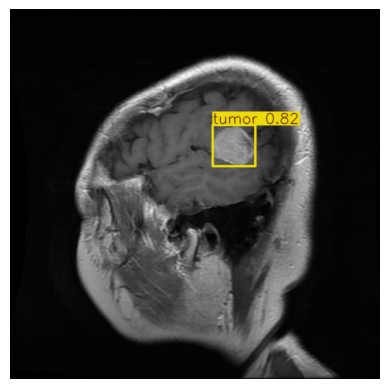

In [ ]:
import matplotlib.pyplot as plt

test_image = "/content/drive/MyDrive/CV Project/brain_tumor_dataset/images/588.png"
results = model_1(test_image)  # Run inference

# Display the image with predictions
res_plotted = results[0].plot()
plt.imshow(res_plotted)  # Convert BGR to RGB
plt.axis("off")
plt.show()